# Part 1: Network Training

In [27]:
# # 強制 Python 回收記憶體
# import gc

# gc.collect()

## Step0: Import Package & Hyperparameter Configuration

### Package

In [28]:
import os
import torch
import random
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

### Hyperparameter Config

In [29]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 1500
    BATCH_SIZE = 256
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 100
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30
    MAXOUT_H = 1


# Reproducibility
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [30]:
material = "CH467160"
model_name = "CH467160_uesed for PFC_test1_batchsize=256_20250804"
downsample = 1024
save_figure = True

# 定義保存模型的路徑
model_save_path = f"./Model/{model_name}.pt"

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [31]:
# %% Preprocess data into a data loader
def get_dataloader(data_B,
                   data_F,
                   data_T,
                   data_H,
                   data_N,
                   data_Hdc,
                   data_Pcv,
                   norm,
                   n_init=16):

    # Data pre-process

    # ── 0. 全域設定/降階設定 ──────────────────────────────
    eps = 1e-8  # 防止除以 0
    if downsample == 1024:
        seq_length = 1024  # 單筆波形點數 (不再 down-sample)
    else:
        seq_length = downsample
        cols = np.linspace(0, 1023, seq_length, dtype=int)
        data_B = data_B[:, cols]
        data_H = data_H[:, cols]

    # ── 1. 波形拼接 (補 n_init 點作初始磁化) ────
    data_length = seq_length + n_init
    data_B = np.hstack((data_B[:, -n_init:], data_B))  # (batch, data_length)
    data_H = np.hstack((data_H[:, -n_init:], data_H))

    # ── 2. 轉成 Tensor ───────────────────────────
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()  # (B,N,1)
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())  # 純量
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Hdc = torch.from_numpy(data_Hdc).view(-1, 1).float()
    N = torch.from_numpy(data_N).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # ── 3. 每筆樣本各自找最大幅值 (per-profile scale) ─
    scale_B = torch.max(torch.abs(B), dim=1,
                        keepdim=True).values + eps  # (B,1,1)
    scale_H = torch.max(torch.abs(H), dim=1, keepdim=True).values + eps

    # ── 4. 先計算導數，再除以 scale_B ─────────────
    dB = torch.diff(B, dim=1, prepend=B[:, :1])
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))  # 真實斜率
    d2B = torch.diff(dB, dim=1, prepend=dB[:, :1])
    d2B_dt = d2B * (seq_length * F.view(-1, 1, 1))

    # ── 5. 形成模型輸入 (已經縮放到 [-1,1]) ────────
    in_B = B / scale_B
    out_H = H / scale_H  # 預測目標
    in_dB_dt = dB_dt / scale_B
    in_d2B_dt = d2B_dt / scale_B

    # ── 6. 純量特徵：計算 z-score 參數 ─────────────
    # Data Normalization
    in_F = (F - norm[0][0]) / norm[0][1]  # F
    in_T = (T - norm[1][0]) / norm[1][1]  # T
    in_Hdc = (Hdc - norm[2][0]) / norm[2][1]  # Hdc
    in_N = (N - norm[3][0]) / norm[3][1]  # N
    # in_Pcv = (Pcv - norm[4][0]) / norm[4][1]  # Pcv
    target_Pcv = Pcv  # (B,1)  # 這裡不做 z-score，直接用原始值

    # ── 7. 產生初始 Preisach operator 狀態 s0 ──────
    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)
    s0 = get_operator_init(in_B[:, 0] - dB[:, 0] / scale_B.squeeze(-1),
                           dB / scale_B, max_B, min_B)

    # ── 8. 組合 Dataset ─────────────────────
    wave_inputs = torch.cat((in_B, dB / scale_B, in_dB_dt, in_d2B_dt),
                            dim=2)  # (B,L,4)
    aux_features = torch.cat((in_F, in_T, in_Hdc, in_N), dim=1)  # (B,4)
    amps = torch.cat((scale_B.squeeze(-1), scale_H.squeeze(-1)),
                     dim=1)  # (B,2)

    test_dataset = torch.utils.data.TensorDataset(
        wave_inputs,  # 0  → 模型序列輸入
        aux_features,  # 1  → 4 個純量
        amps,  # 2  → 幅值係數
        s0,  # 3  → Preisach 初始狀態
        out_H,  # 4  → 目標 H  (已 scale_H)
        target_Pcv)  # 5  → 目標 Pcv (已 z-score)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=Config.BATCH_SIZE,
                                              shuffle=False,
                                              collate_fn=filter_input)

    return test_loader


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=Config.MAXOUT_H,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, amps, s0, target_H, target_Pcv = zip(*batch)

    inputs = torch.stack(inputs)
    features = torch.stack(features)
    amps = torch.stack(amps)
    s0 = torch.stack(s0)
    target_H = torch.stack(target_H)[:, -downsample:, :]  # 保留全長
    target_Pcv = torch.stack(target_Pcv)  # (B,1)

    # return inputs, features, s0, target_H, target_Pcv
    return inputs, features, amps, s0, target_H, target_Pcv


### Material normalization data

In [32]:
# %%
# Material normalization data: 0.F, 1.T, 2.Hdc, 3.N, 4.Pcv
normsDict = {
    "CH467160": [[2.0, 1.0], [25.0, 1.0],
                 [1287.258056640625, 705.1074829101562],
                 [14.199999809265137, 4.453069686889648],
                 [1.6449116468429565, 0.7523635029792786]]
}

## Step2: Define Network Structure

In [33]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
# ! - var_size: number of supplenmentary variables (1.F 2.T 3.Hdc 4.N)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):

    def __init__(
            self,
            Material,  #*這裡改成從外部傳入 norm(250203)
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=4,
            var_size=4,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = normsDict[Material]

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + self.var_size, 1)
        # 5 (F, T, B, dB/dt, d2B/dt ) + 2 (Hdc, N)
        self.rnn2 = EddyCell(7, self.hidden_size, output_size)
        self.dnn2 = nn.Linear(self.hidden_size, 1)
        self.rnn2_hx = None
        # var_size=4: F, T, Hdc, N + 1 for P_prelim
        self.loss_mlp = nn.Sequential(
            nn.Linear(self.var_size + 1,
                      64),  # var_size=4: F, T, Hdc, N + 1 for P_prelim
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(32, 1))

    def forward(self, x, var, amps, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
#         - var(batch,var_size): Supplementary inputs (1.F 2.T 3.Hdc 4.N) 
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # !Initialize DNN2 input (1.B 2.dB/dt 3.d2B)
        # x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:4]),
                       dim=2)  # !選取 B, dB/dt, d2B

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T,Hdc,N)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        amp_B = amps[:, 0:1]  # (batch,1)
        amp_H = amps[:, 1:2]  # (batch,1)
        B_amp = x[:, n_init:, 0:1] * amp_B.unsqueeze(1)
        H_amp = output[:, n_init:, :] * amp_H.unsqueeze(1)
        P_prelim = torch.trapz(H_amp, B_amp, axis=1) * (10**(
            var[:, 0:1] * self.norm[0][1] + self.norm[0][0]))
        Pcv_log = torch.log10(P_prelim.clamp(min=1e-12))
        Pcv = (Pcv_log - self.norm[4][0]) / self.norm[4][1]
        mlp_input = torch.cat((var, Pcv), dim=1)  # (batch, 5)
        s = self.loss_mlp(mlp_input)
        Pcv_mlp = Pcv + s

        return torch.flatten(Pcv_mlp), H_amp, B_amp


class StopOperatorCell():

    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(Config.MAXOUT_H / operator_size, Config.MAXOUT_H,
                        operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden


## Step3: Training the Model

### Load Dataset

In [34]:
# Load Data
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/test/B_Field.csv"
    in_file2 = f"{base_path}{material}/test/Frequency.csv"
    in_file3 = f"{base_path}{material}/test/Temperature.csv"
    in_file4 = f"{base_path}{material}/test/H_Field.csv"
    in_file5 = f"{base_path}{material}/test/Volumetric_Loss.csv"
    in_file6 = f"{base_path}{material}/test/Hdc.csv"
    in_file7 = f"{base_path}{material}/test/Turns.csv"

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N x 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N x 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N x 1
    data_Hdc = np.genfromtxt(in_file6, delimiter=',')  # N x 1
    data_N = np.genfromtxt(in_file7, delimiter=',')  # N x 1

    return data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N

### Test Code

In [35]:
def test_model(test_loader, measured_Pcv, original_B, original_H):
    """
    test_loader: 測試集 DataLoader
    measured_Pcv: 原始測量的損耗 (Pcv)
    original_B, original_H: 原始未降階的 B 與 H（用於參考繪圖）
    """
    model = MMINet(Material=material).to(device)
    model.load_state_dict(torch.load(model_save_path))
    model.eval()

    yy_pred_list, yy_pred_H_list, down_B_list = [], [], []

    with torch.no_grad():
        for inputs, features, amps, s0, target_H, _ in test_loader:
            inputs, features, amps, s0 = (
                inputs.to(device),
                features.to(device),
                amps.to(device),
                s0.to(device),
            )
            # -------------------------------------------------------------
            # 訓練版 forward() 應回傳「z-score 的 log10(Pcv)」
            # -------------------------------------------------------------
            pred_z, pred_H, down_B = model(inputs, features, amps, s0)
            yy_pred_list.append(pred_z.cpu().numpy())
            yy_pred_H_list.append(pred_H.cpu().numpy())
            down_B_list.append(down_B.cpu().numpy())

    # ---------- 串接 batch ----------
    pred_z = np.concatenate(yy_pred_list, axis=0)  # (N,)
    pred_H = np.concatenate(yy_pred_H_list, axis=0)  # (N, L)
    down_B = np.concatenate(down_B_list, axis=0)  # (N, L)

    # === 這段開始：還原尺度 & 計算誤差 ======================================
    mu, sigma = normsDict[material][4]  # 第 4 個是 Pcv 的 [μ, σ]

    pred_log = pred_z * sigma + mu  # 反 z-score → log10(Pcv)
    pred_pcv = 10**pred_log  # 線性尺度  (W/cm³)

    measured_pcv = measured_Pcv.flatten()  # 保險起見扁平化
    eps = 1e-12
    Error_re = np.abs(pred_pcv - measured_pcv) / (np.abs(measured_pcv) +
                                                  eps) * 100
    # === 這段結束 =========================================================

    print(f"Relative Error: {np.mean(Error_re):.8f}")
    print(f"AVG Error: {np.mean(Error_re):.8f}")
    print(f"95-PRCT Error: {np.percentile(Error_re, 95):.8f}")
    print(f"99th Percentile Error: {np.percentile(Error_re, 99):.8f}")
    print(f"MAX Error: {np.max(Error_re):.8f}")
    print(f"MIN Error: {np.min(Error_re):.8f}")

    sorted_idx = np.argsort(Error_re)[::-1]
    max1_idx = sorted_idx[0]
    max2_idx = sorted_idx[1]
    print(f"第一大誤差索引: {max1_idx}, 誤差值: {Error_re[max1_idx]:.8f}%")
    print(f"第二大誤差索引: {max2_idx}, 誤差值: {Error_re[max2_idx]:.8f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(pred_pcv, label="Predicted Pcv", linestyle="-", marker='x')
    plt.plot(measured_Pcv, label="Actual Pcv", linestyle="--", marker='x')
    plt.legend()
    plt.xlabel("Test Samples")
    plt.ylabel("Pcv")
    plt.title("Comparison of Predicted and Actual Core Loss")
    plt.show()

    eps = 1e-12  # 防止 log(0)
    pred_log = np.log10(pred_pcv + eps)
    measured_log = np.log10(measured_pcv + eps)
    rel_err_log = np.abs(pred_log - measured_log) * 100  # ← 兩個都是 log10
    print(f"Relative Log Error: {np.mean(rel_err_log):.8f}")
    print(f"AVG Log Error: {np.mean(rel_err_log):.8f}")
    print(f"95-PRCT Log Error: {np.percentile(rel_err_log, 95):.8f}")
    print(f"99th Percentile Log Error: {np.percentile(rel_err_log, 99):.8f}")
    print(f"MAX Log Error: {np.max(rel_err_log):.8f}")
    print(f"MIN Log Error: {np.min(rel_err_log):.8f}")

    # ================= 新增繪圖 =================
    # # (a) 原始資料：x 軸 B，y 軸 H
    # for i in range(original_B.shape[0]):
    #     plt.figure(figsize=(8, 4))
    #     plt.plot(original_B[i, :], original_H[i, :], marker='o', markersize=1, label="Original H")
    #     plt.xlabel("B")
    #     plt.ylabel("H")
    #     plt.title(f"Original Data Sample #{i} (B vs H)")
    #     plt.legend()
    #     plt.grid(alpha=0.3)
    #     plt.show()

    # # (b) 降階後資料（預測）：x 軸降階後的 B，y 軸預測 H
    # for i in range(down_B.shape[0]):
    #     plt.figure(figsize=(8, 4))
    #     plt.plot(down_B[i, :], pred_H[i, :], marker='x', markersize=1, label="Predicted H")
    #     plt.xlabel("B")
    #     plt.ylabel("H")
    #     plt.title(f"Downsampled Data Sample #{i} - B vs Predicted H")
    #     plt.legend()
    #     plt.grid(alpha=0.3)
    #     plt.show()

    # # (c) 降階後資料（測量）：x 軸降階後的 B，y 軸測量 H
    # for i in range(down_B.shape[0]):
    #     plt.figure(figsize=(8, 4))
    #     plt.plot(down_B[i, :], yy_gt_H[i, :], marker='x', markersize=3, label="Measured H")
    #     plt.xlabel("B")
    #     plt.ylabel("H")
    #     plt.title(f"Downsampled Data Sample #{i} - B vs Measured H")
    #     plt.legend()
    #     plt.grid(alpha=0.3)
    #     plt.show()
    # ================= 繪圖結束 =================

    # 儲存預測結果
    df = pd.DataFrame(pred_pcv)
    df_H = pd.DataFrame(pred_H.squeeze(-1))  # (N, 1024)
    df_H_target = pd.DataFrame(original_H)
    output_path = f"./Output/{material}_predictions.csv"
    df.to_csv(output_path, index=False, header=False)
    outputH_path = f"./Output/{material}_predictions_H.csv"
    df_H.to_csv(outputH_path, index=False, header=False)
    meas_H_path = f"./Output/{material}_measured_H.csv"
    df_H_target.to_csv(meas_H_path, index=False, header=False)
    print(f"預測結果已匯出至 {output_path}")

    # ================= 修改區結束 =================

    # ====== 純 matplotlib 畫誤差分布圖（Relative Error） ======

    # 計算統計值
    avg_err = np.mean(Error_re)
    pct95 = np.percentile(Error_re, 95)
    max_err = np.max(Error_re)

    # 畫直方圖（normalized 為比例）
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(Error_re,
                                     bins=100,
                                     density=True,
                                     color='navy',
                                     alpha=0.9)

    # 加上垂直虛線與文字
    plt.axvline(avg_err, color='red', linestyle='--', linewidth=1.5)
    plt.text(avg_err + 0.5,
             0.09,
             f"Avg={avg_err:.3f}%",
             color='red',
             fontsize=12)

    plt.axvline(pct95, color='red', linestyle='--', linewidth=1.5)
    plt.text(pct95 + 0.5,
             0.07,
             f"95-Prct={pct95:.2f}%",
             color='red',
             fontsize=12)

    plt.axvline(max_err, color='red', linestyle='--', linewidth=1.5)
    plt.text(max_err - 10,
             0.03,
             f"Max={max_err:.2f}%",
             color='red',
             fontsize=12)

    # 加上標題與標籤
    plt.title(f"Error Distribution for {material}", fontsize=16)
    plt.xlabel("Relative Error of Sequence [%]")
    plt.ylabel("Ratio of Data Points")
    plt.ylim(top=0.1)  # 固定 Y 軸上限方便閱讀
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ====== 純 matplotlib 畫 log 空間誤差分布圖 ======

    # 計算統計值（以 log 空間誤差為基礎）
    avg_log_err = np.mean(rel_err_log)
    pct95_log = np.percentile(rel_err_log, 95)
    pct99_log = np.percentile(rel_err_log, 99)
    max_log_err = np.max(rel_err_log)

    # 畫直方圖（normalized 為比例）
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(rel_err_log,
                                     bins=100,
                                     density=True,
                                     color='darkgreen',
                                     alpha=0.9)

    # 加上垂直虛線與文字標示
    plt.axvline(avg_log_err, color='red', linestyle='--', linewidth=1.5)
    plt.text(avg_log_err + 0.5,
             0.09,
             f"Avg={avg_log_err:.3f}%",
             color='red',
             fontsize=12)

    plt.axvline(pct95_log, color='red', linestyle='--', linewidth=1.5)
    plt.text(pct95_log + 0.5,
             0.07,
             f"95-Prct={pct95_log:.2f}%",
             color='red',
             fontsize=12)

    plt.axvline(max_log_err, color='red', linestyle='--', linewidth=1.5)
    plt.text(max_log_err - 10,
             0.03,
             f"Max={max_log_err:.2f}%",
             color='red',
             fontsize=12)

    # 加上標題與標籤
    plt.title(f"Log Error Distribution for {material}", fontsize=16)
    plt.xlabel("Relative Log Error of Sequence [%]")
    plt.ylabel("Ratio of Data Points")
    plt.ylim(top=0.1)  # 固定 Y 軸上限以對齊視覺
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    last_idx = original_B.shape[0] - 1
    plt.figure(figsize=(8, 6))

    # 原始資料：直接使用 load_dataset 回傳的資料 (B, H)
    plt.plot(original_H[last_idx, :],
             original_B[last_idx, :],
             label="Original (Raw)",
             alpha=0.5)

    # 降階後的：B 與預測 H
    plt.plot(pred_H[last_idx, :], down_B[last_idx, :], label="Predicted H")

    plt.xlabel("H")
    plt.ylabel("B")
    plt.title(f"Buck B-H Pred. vs. Measured")
    plt.legend()
    plt.grid(alpha=0.3)

    n_plots_per_fig = 4  # 每張圖顯示的子圖數量
    n_rows, n_cols = 2, 2  # 四格排版為 2x2

    n_samples = original_B.shape[0]

    for i in range(n_samples):
        # 若為每個新圖的第一個子圖，則建立新圖與子圖陣列
        if i % n_plots_per_fig == 0:
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))

        # 取得目前子圖的索引位置 (row, col)
        index = i % n_plots_per_fig
        row = index // n_cols
        col = index % n_cols
        ax = axs[row, col]

        # 原始資料：直接使用 load_dataset 回傳的資料 (B, H)
        ax.plot(original_H[i, :],
                original_B[i, :],
                label="Original (Raw)",
                alpha=0.5)

        # 降階後的：B 與預測 H
        ax.plot(pred_H[i, :], down_B[i, :], label="Predicted H")

        ax.set_xlabel("H")
        ax.set_ylabel("B")
        ax.set_title(f"Overlay Plot Sample #{i}")
        ax.legend()
        ax.grid(alpha=0.3)

        # 當四個子圖都畫完或已經是最後一個樣本，則調整佈局並顯示圖形
        if (i % n_plots_per_fig == n_plots_per_fig - 1) or (i
                                                            == n_samples - 1):
            plt.tight_layout()
            plt.show()

    # ================= 三種疊圖結束 =================


### Start Test!!!

C:\Users\USER\AppData\Local\Temp\ipykernel_2892\221458967.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Relative Error: 10.41783218
AVG Error: 10.41783218
95-PRCT Error: 22.37429995
99th Percentile Error: 25.64282713
MAX Error: 35.43138647
MIN Error: 0.07414361
第一大誤差索引: 62, 誤差值: 35.43138647%
第二大誤差索引: 207, 誤差值: 26.81689011%


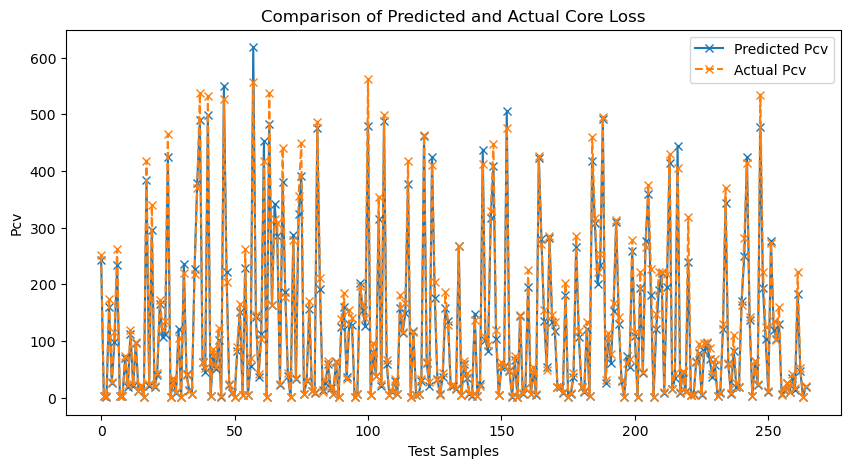

Relative Log Error: 4.76182976
AVG Log Error: 4.76182976
95-PRCT Log Error: 10.44733566
99th Percentile Log Error: 12.33760830
MAX Log Error: 13.17193278
MIN Log Error: 0.03221118
預測結果已匯出至 ./Output/CH467160_predictions.csv


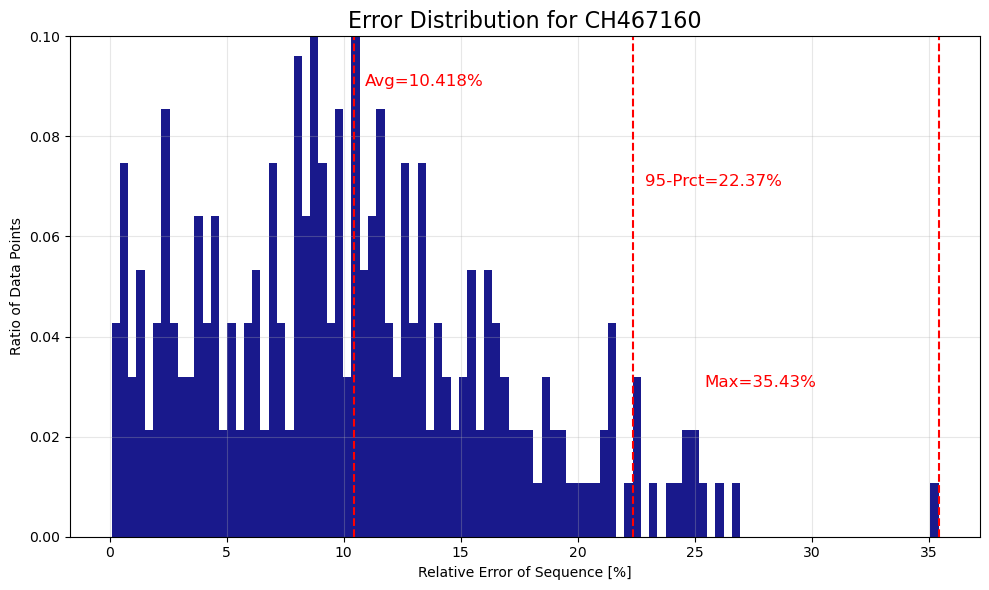

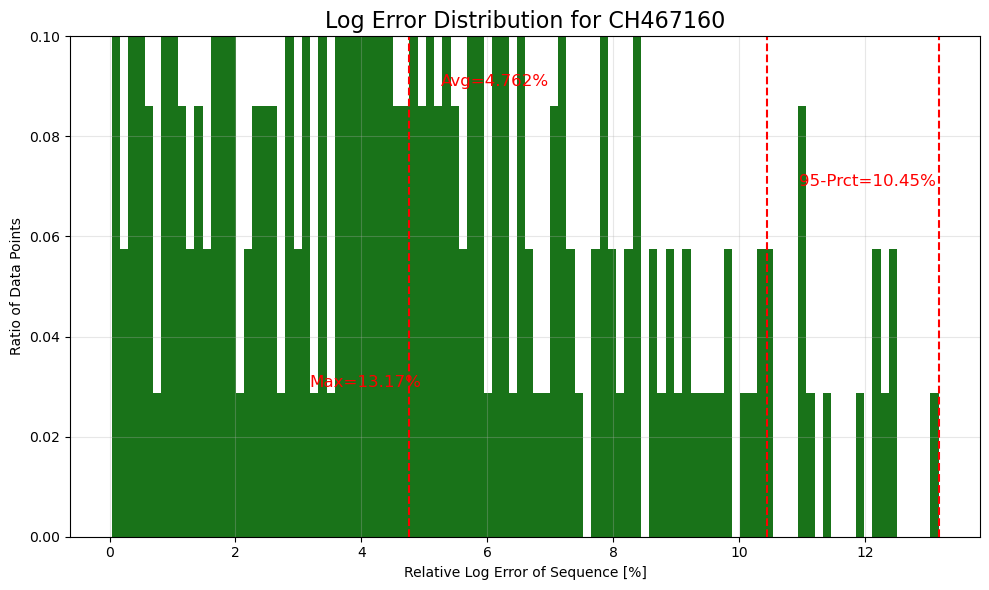

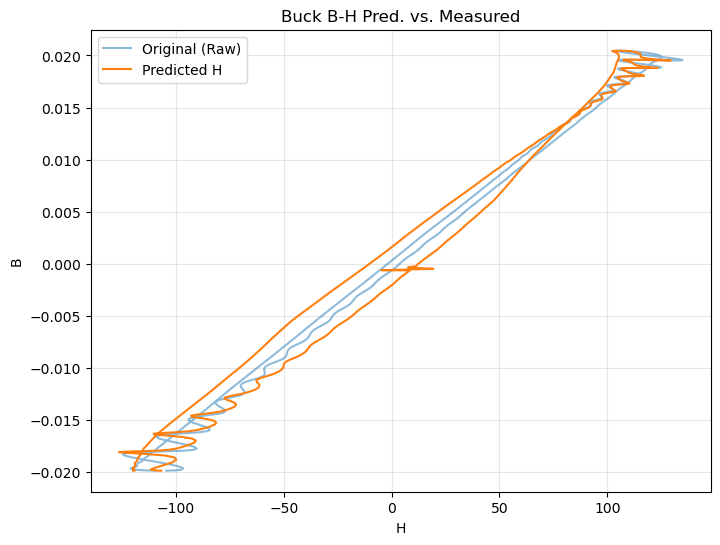

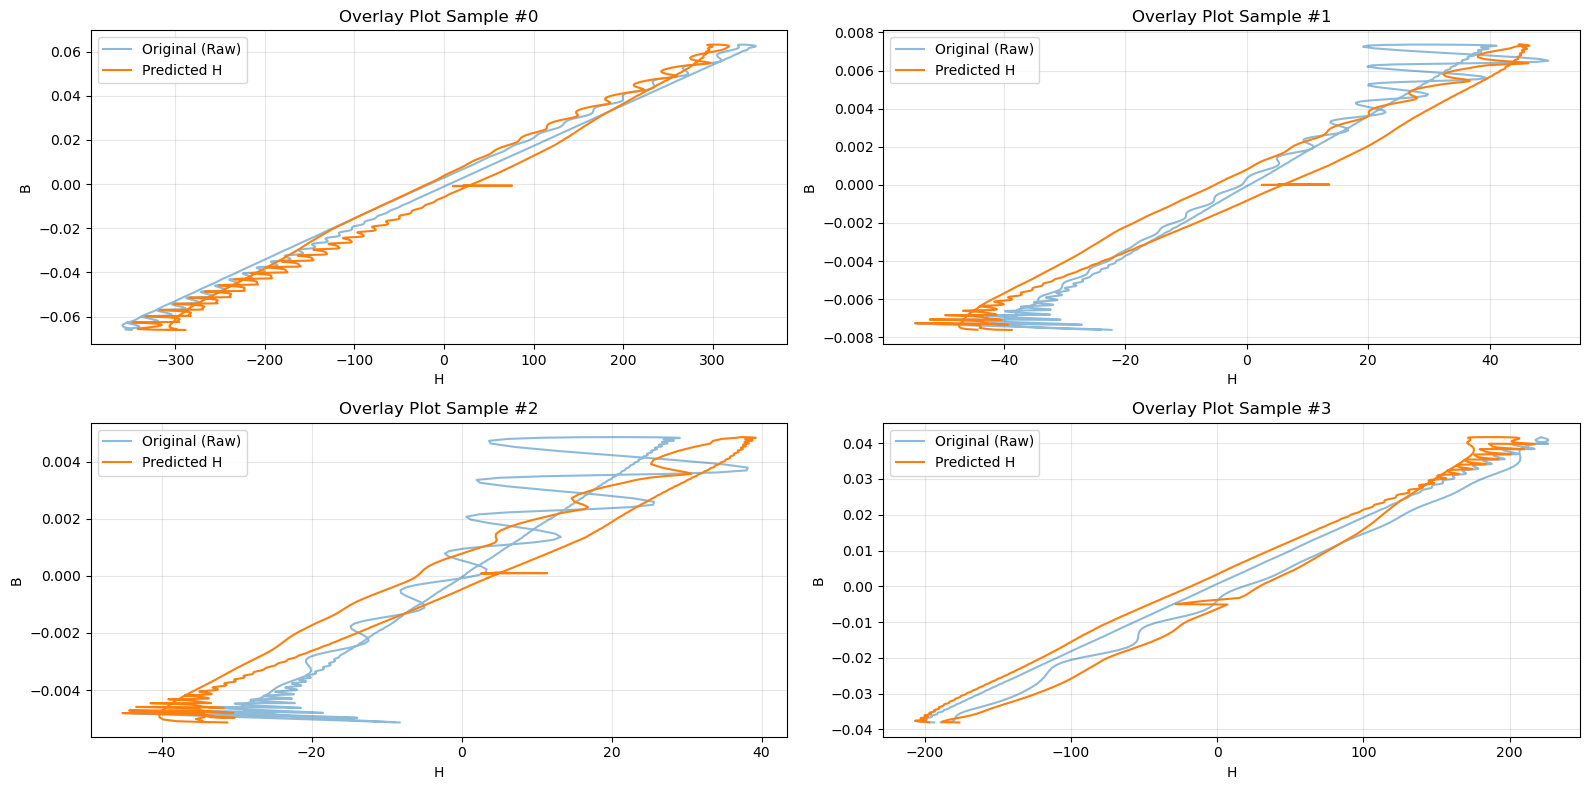

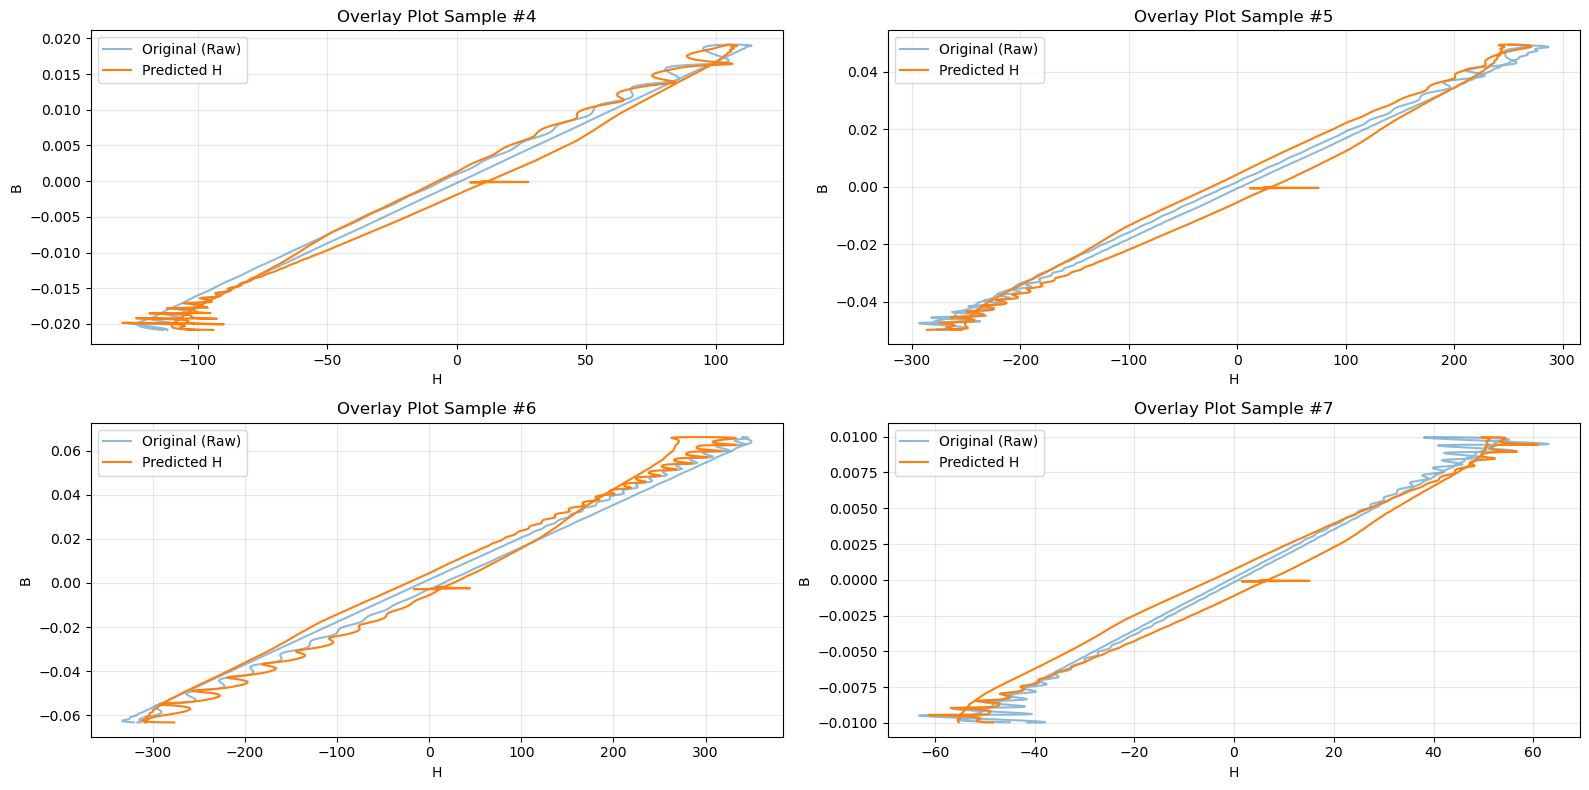

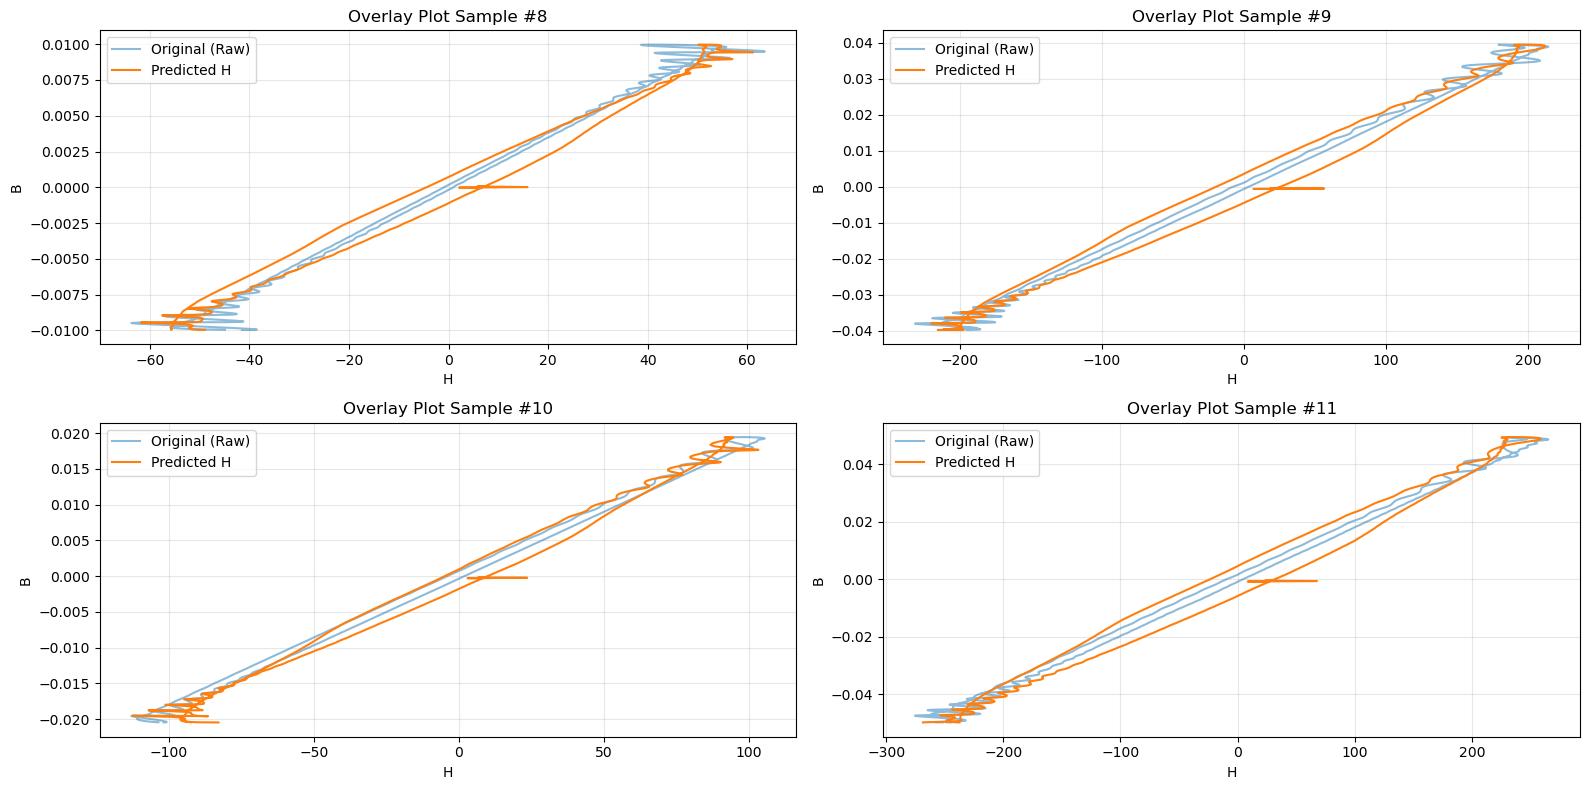

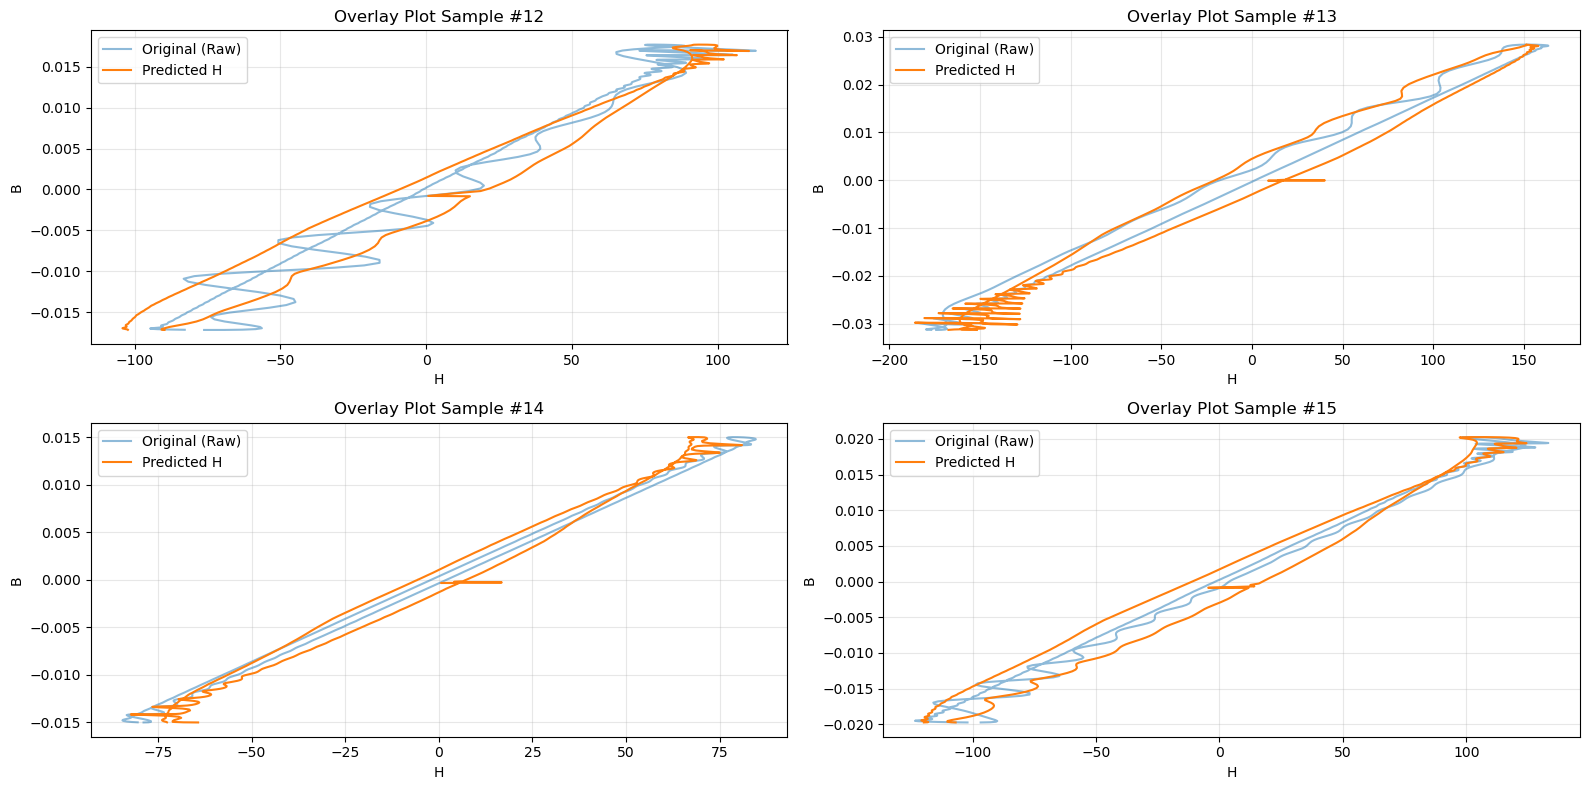

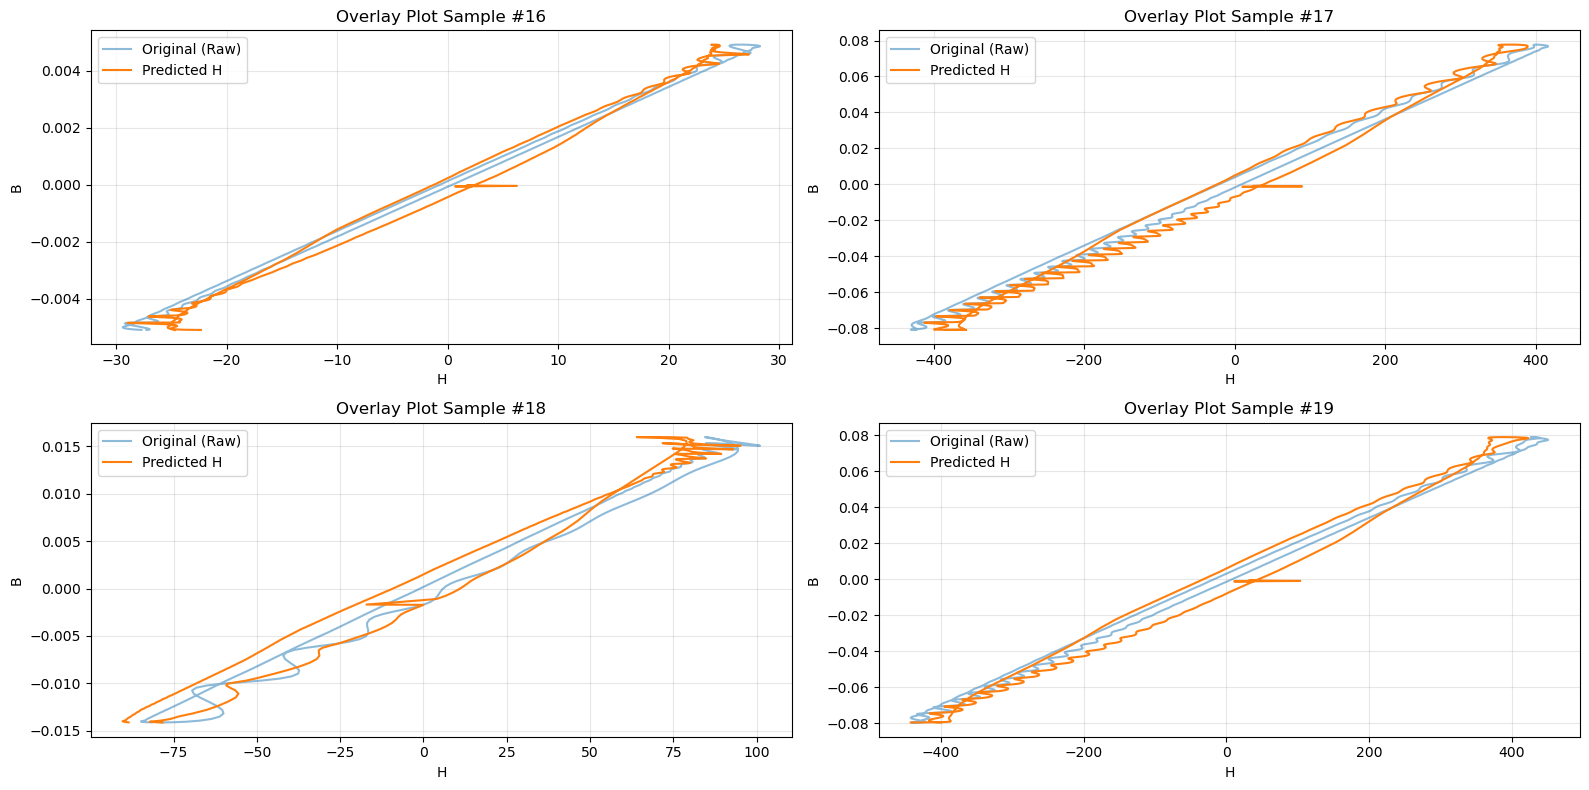

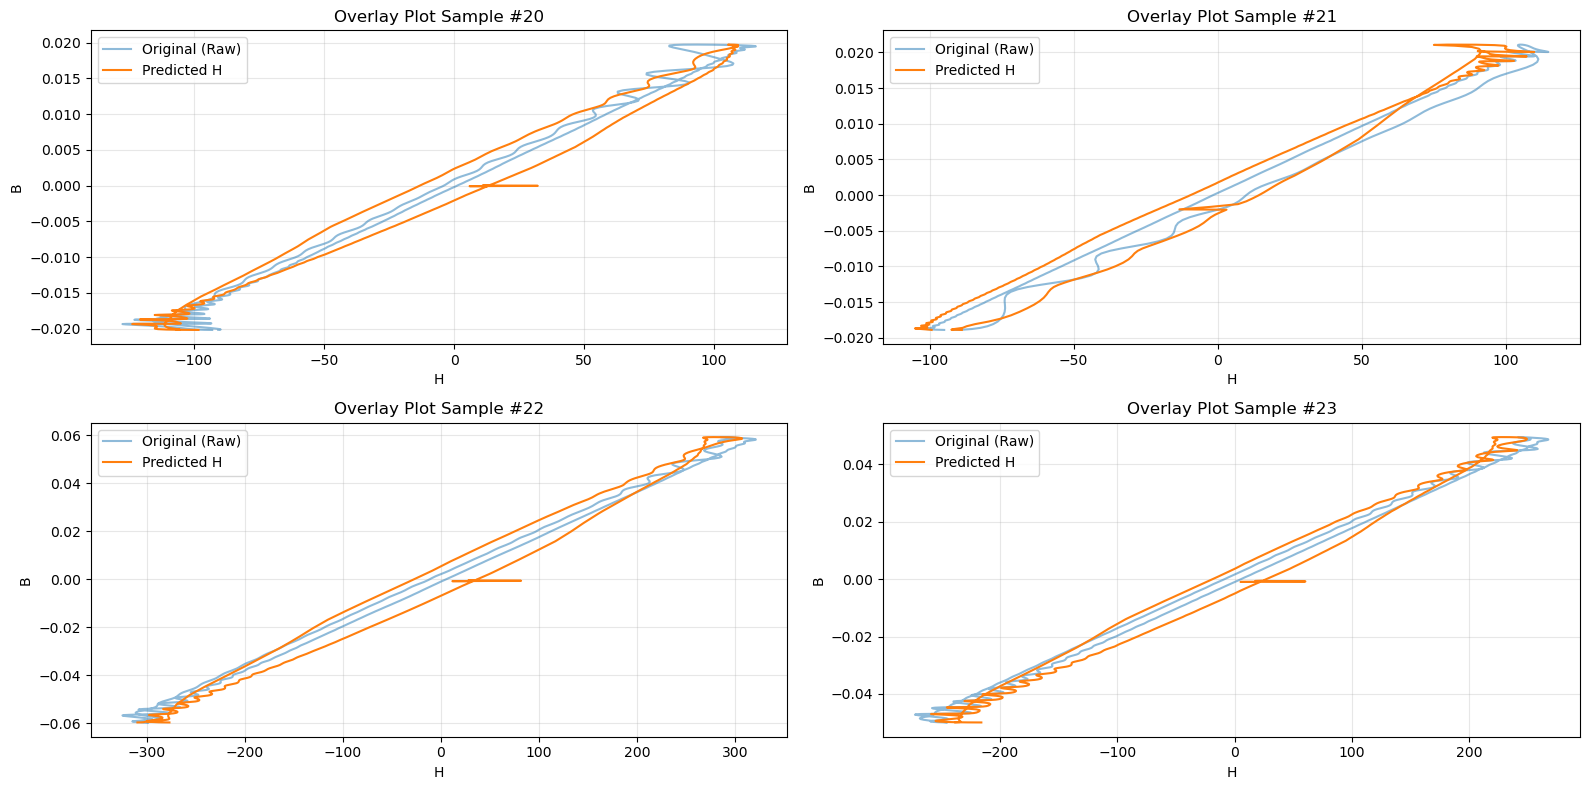

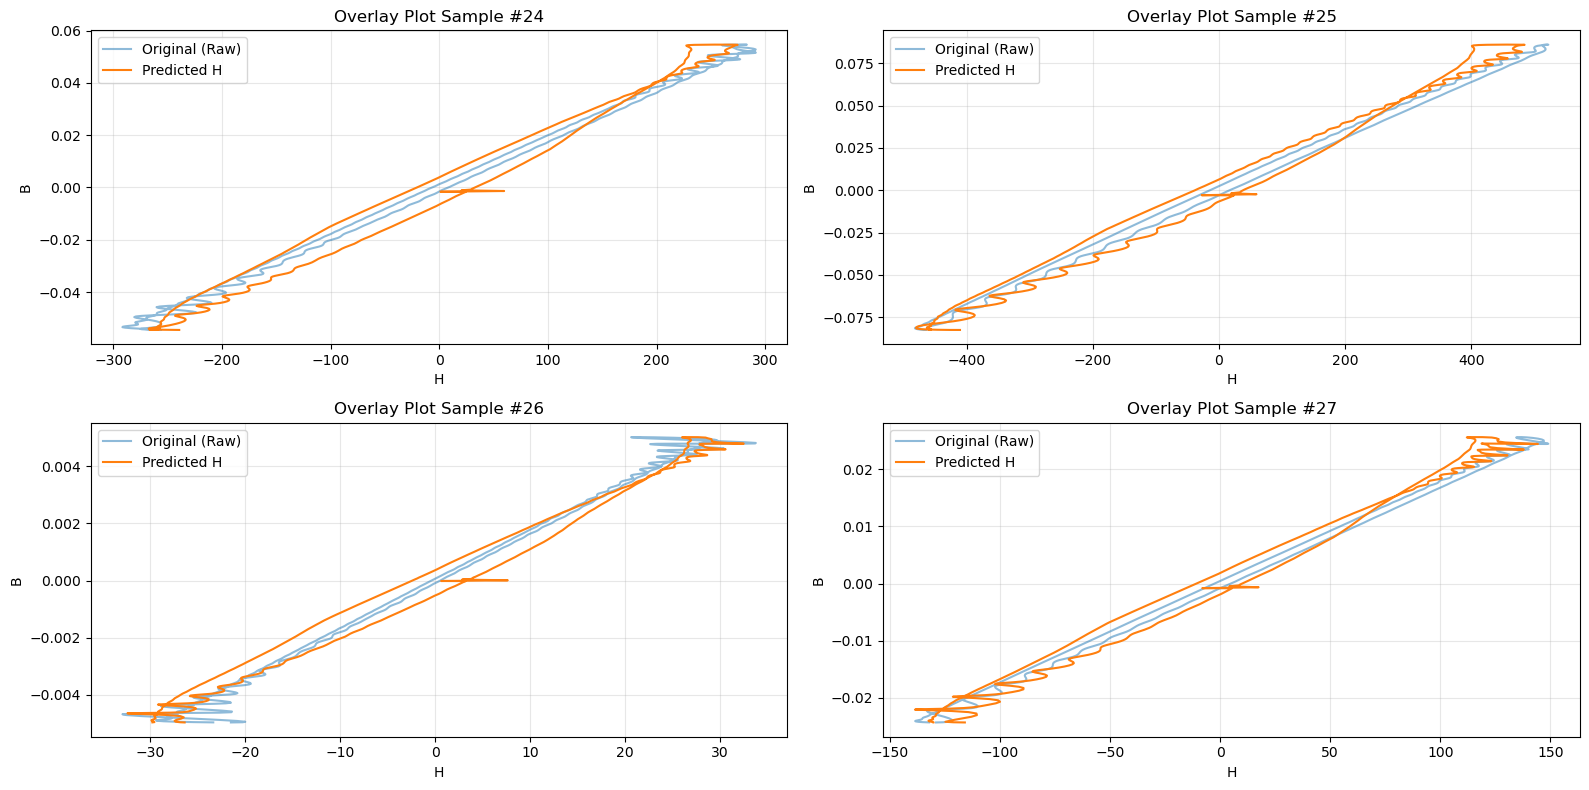

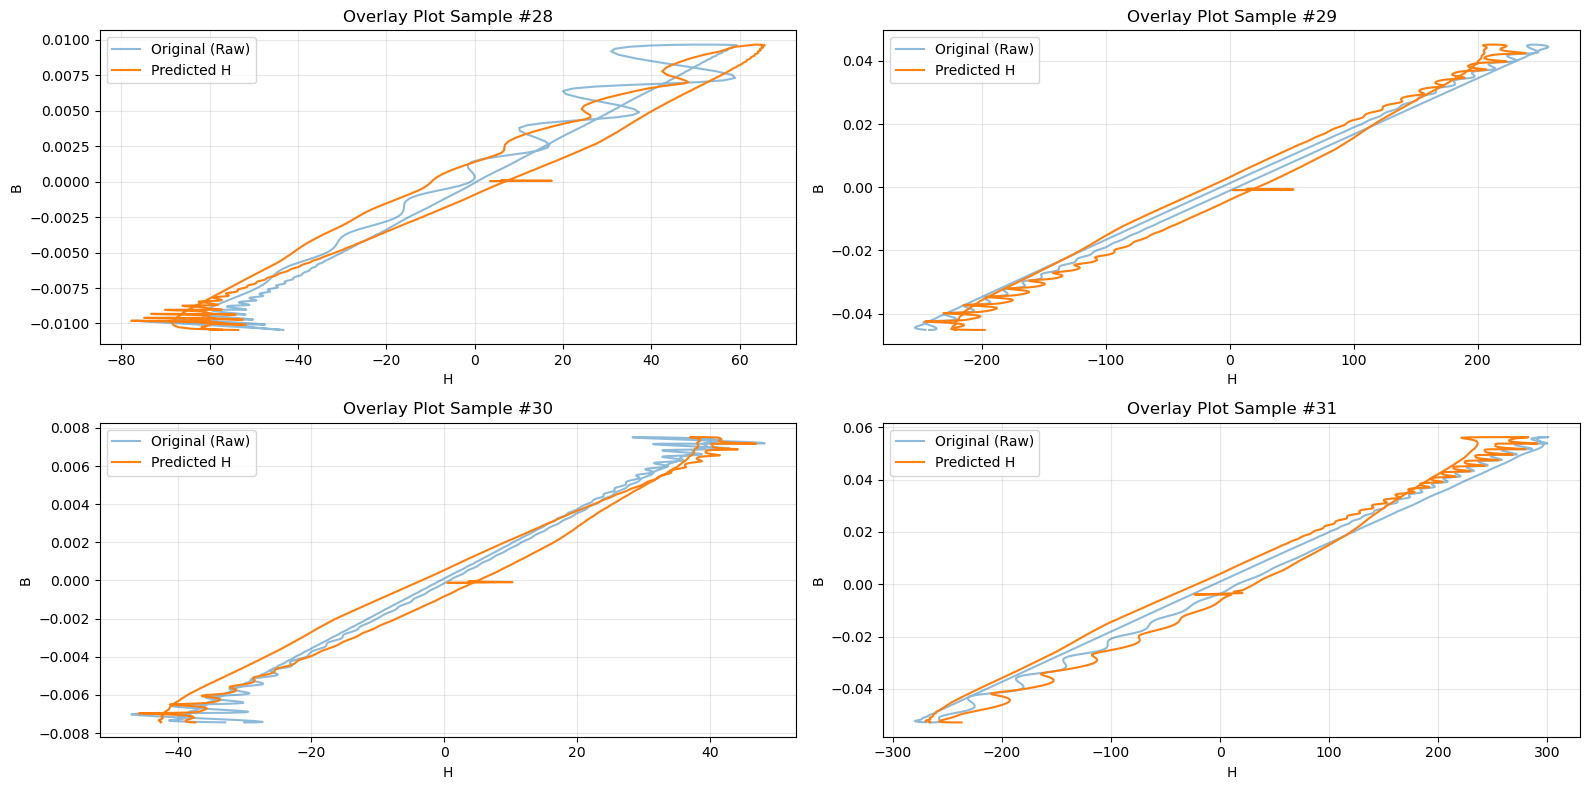

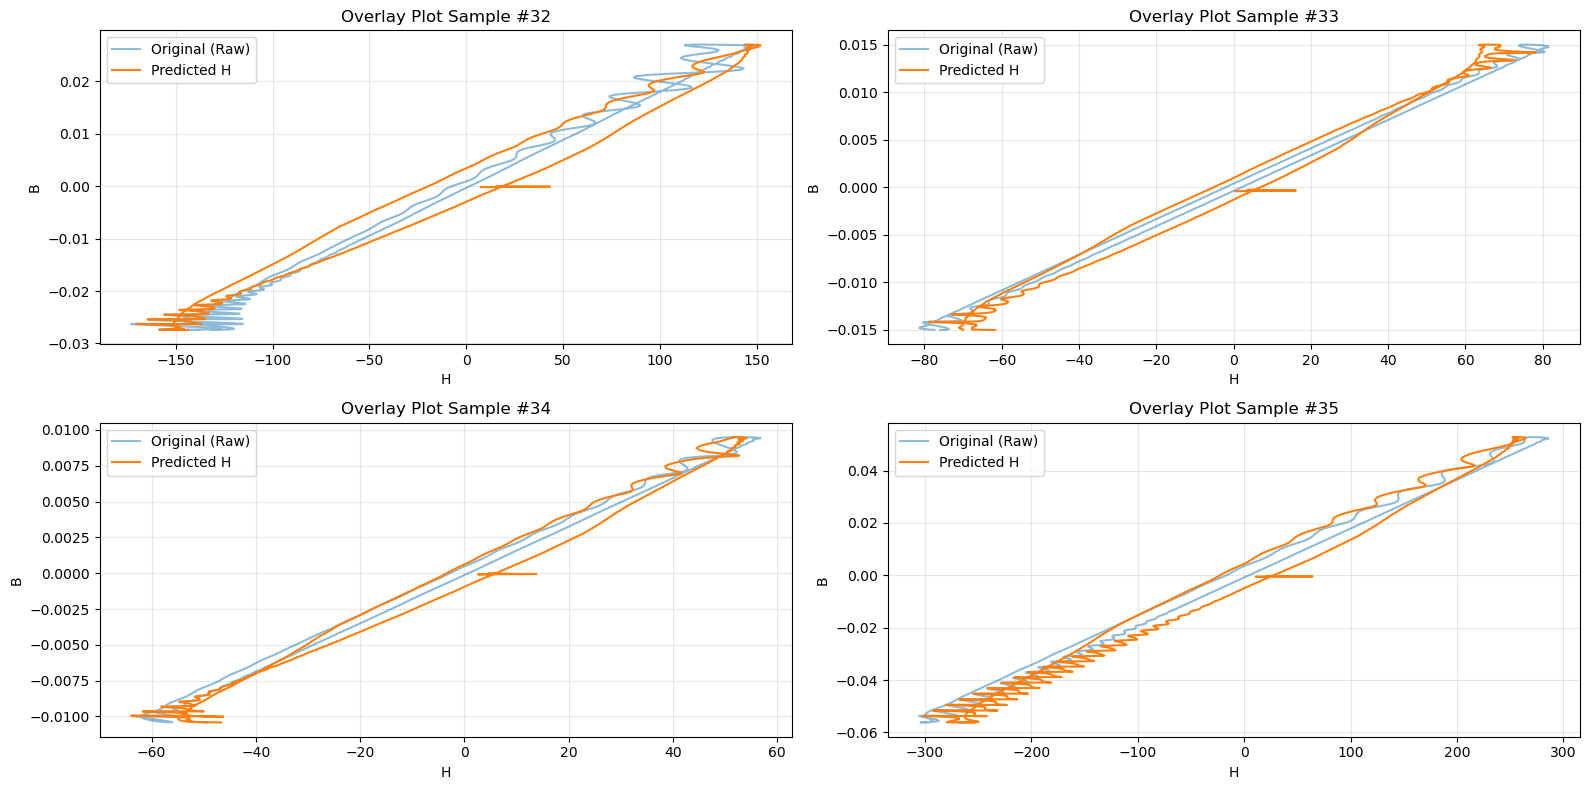

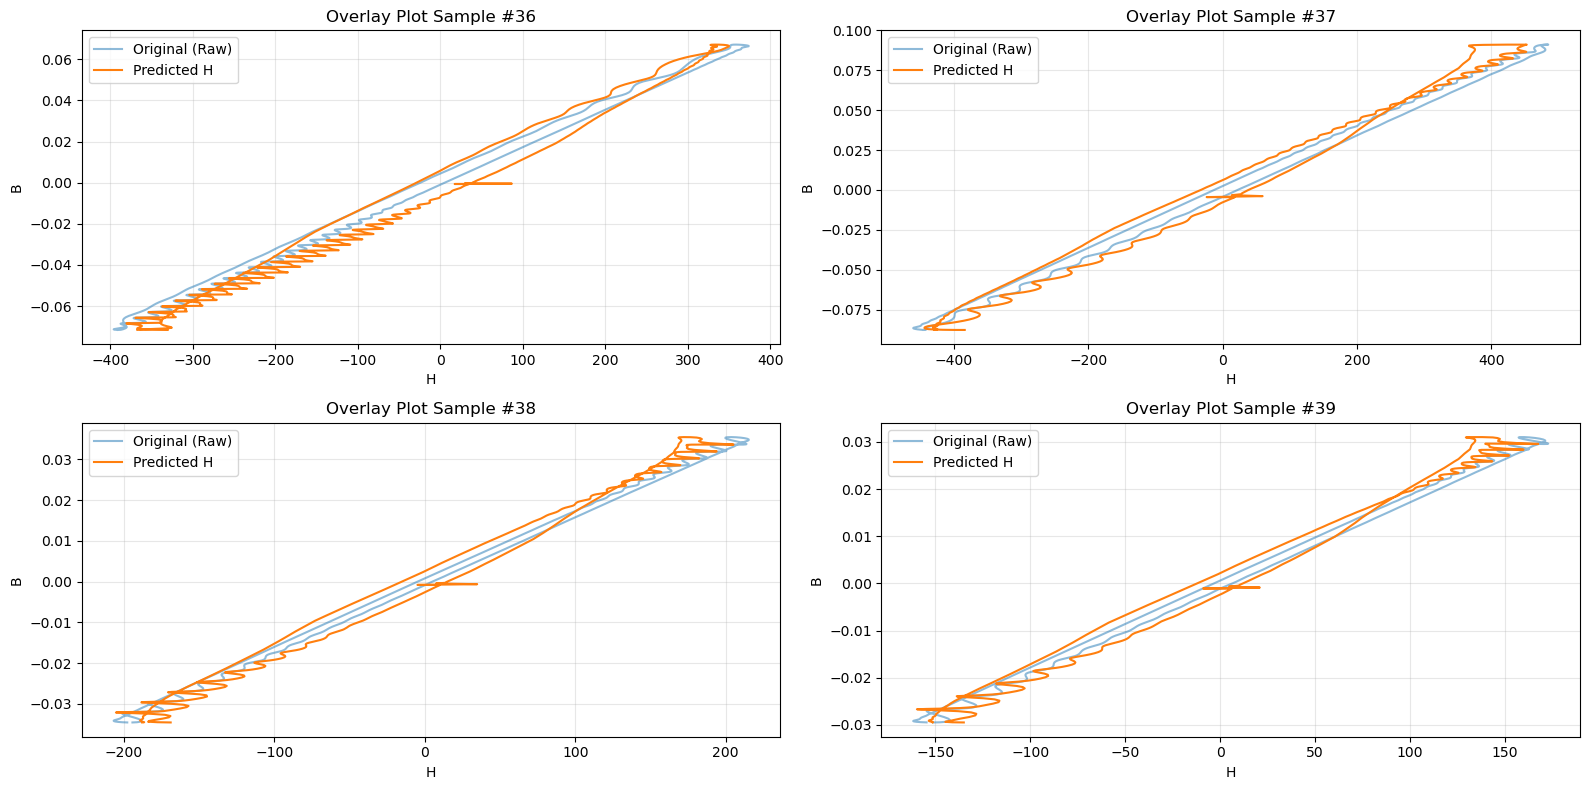

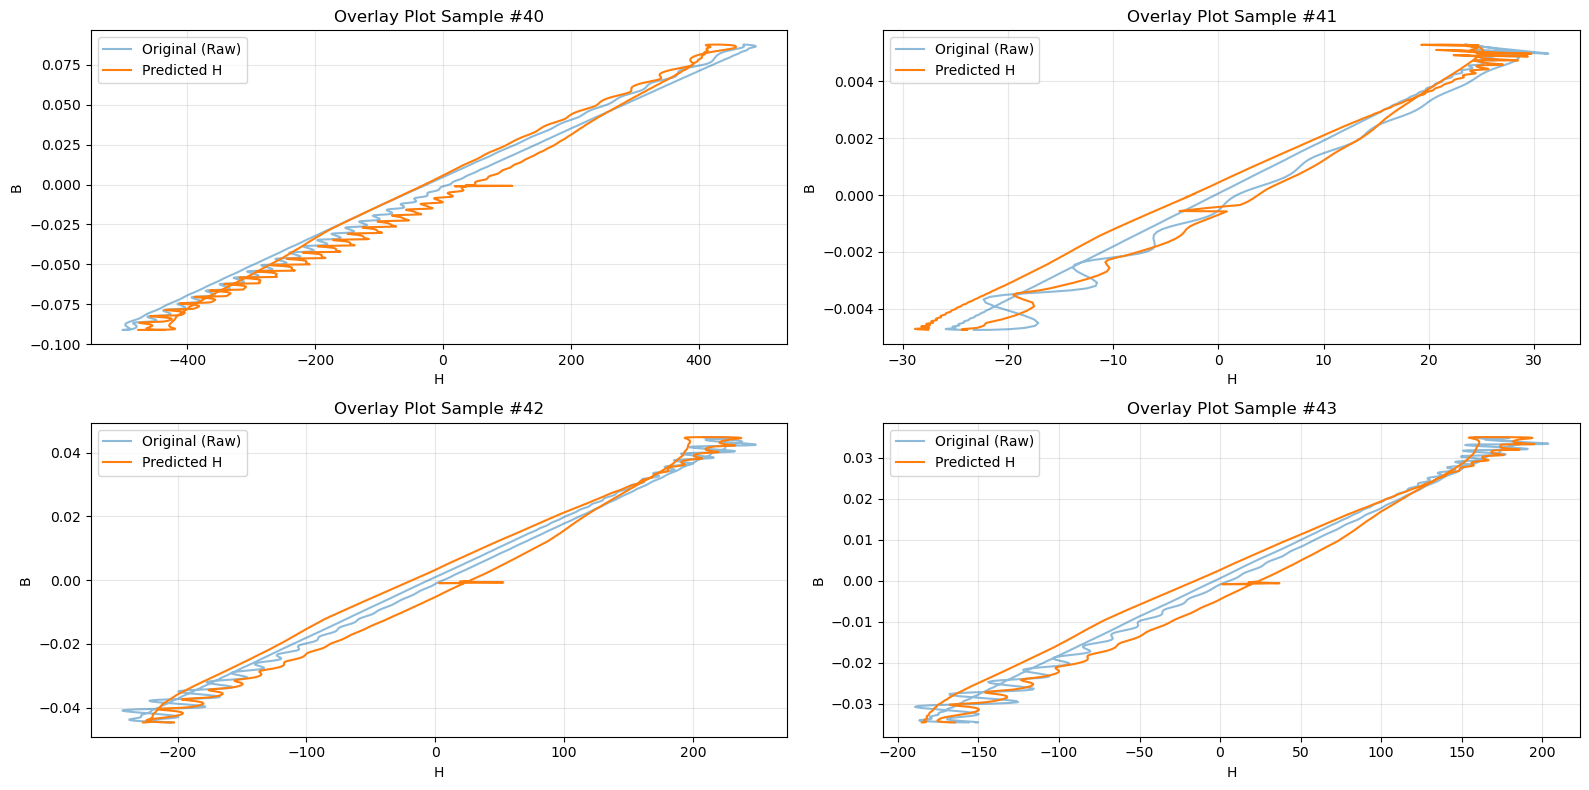

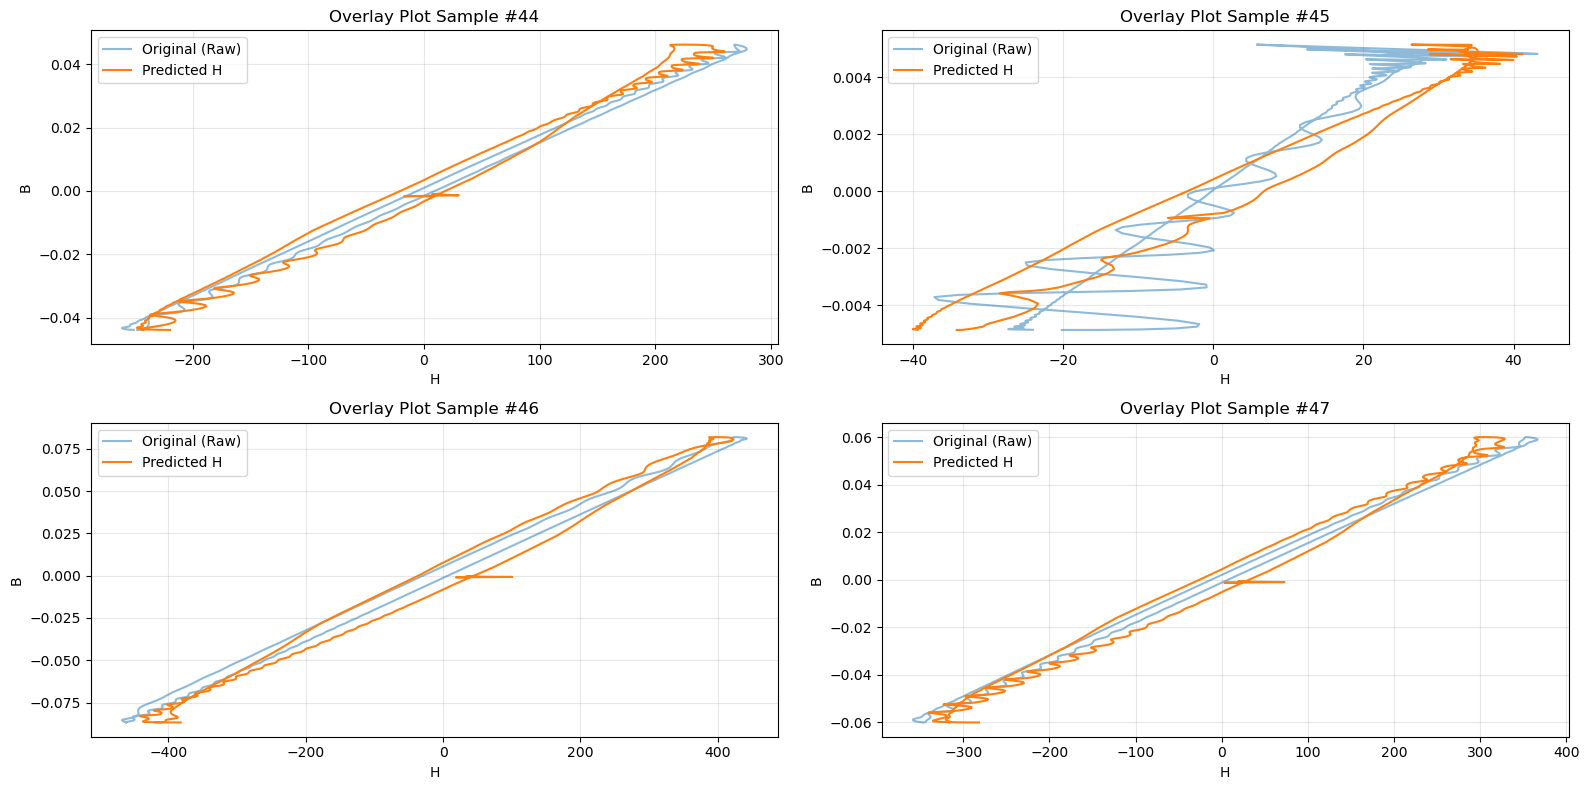

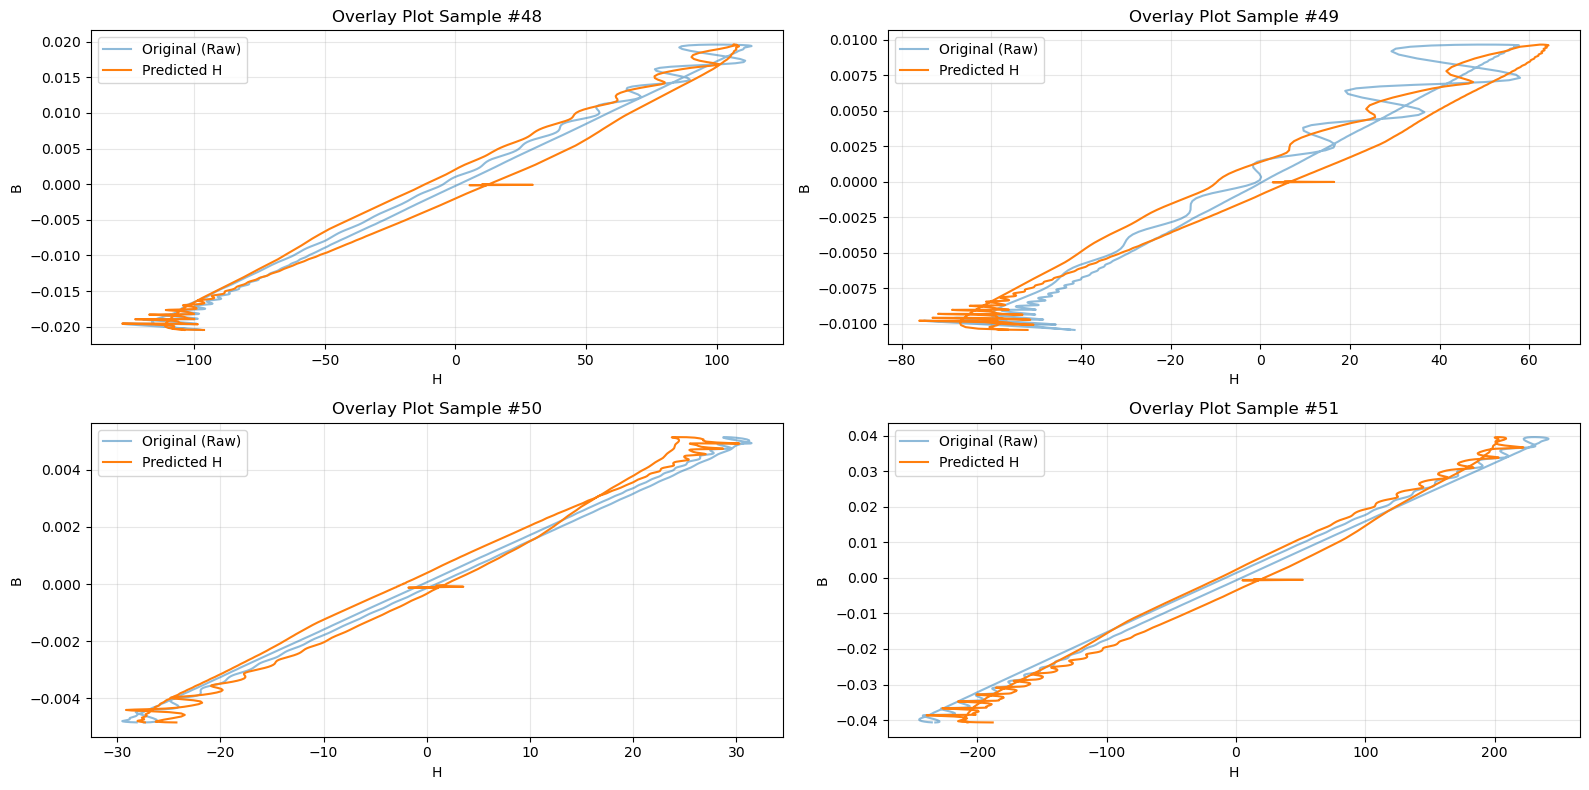

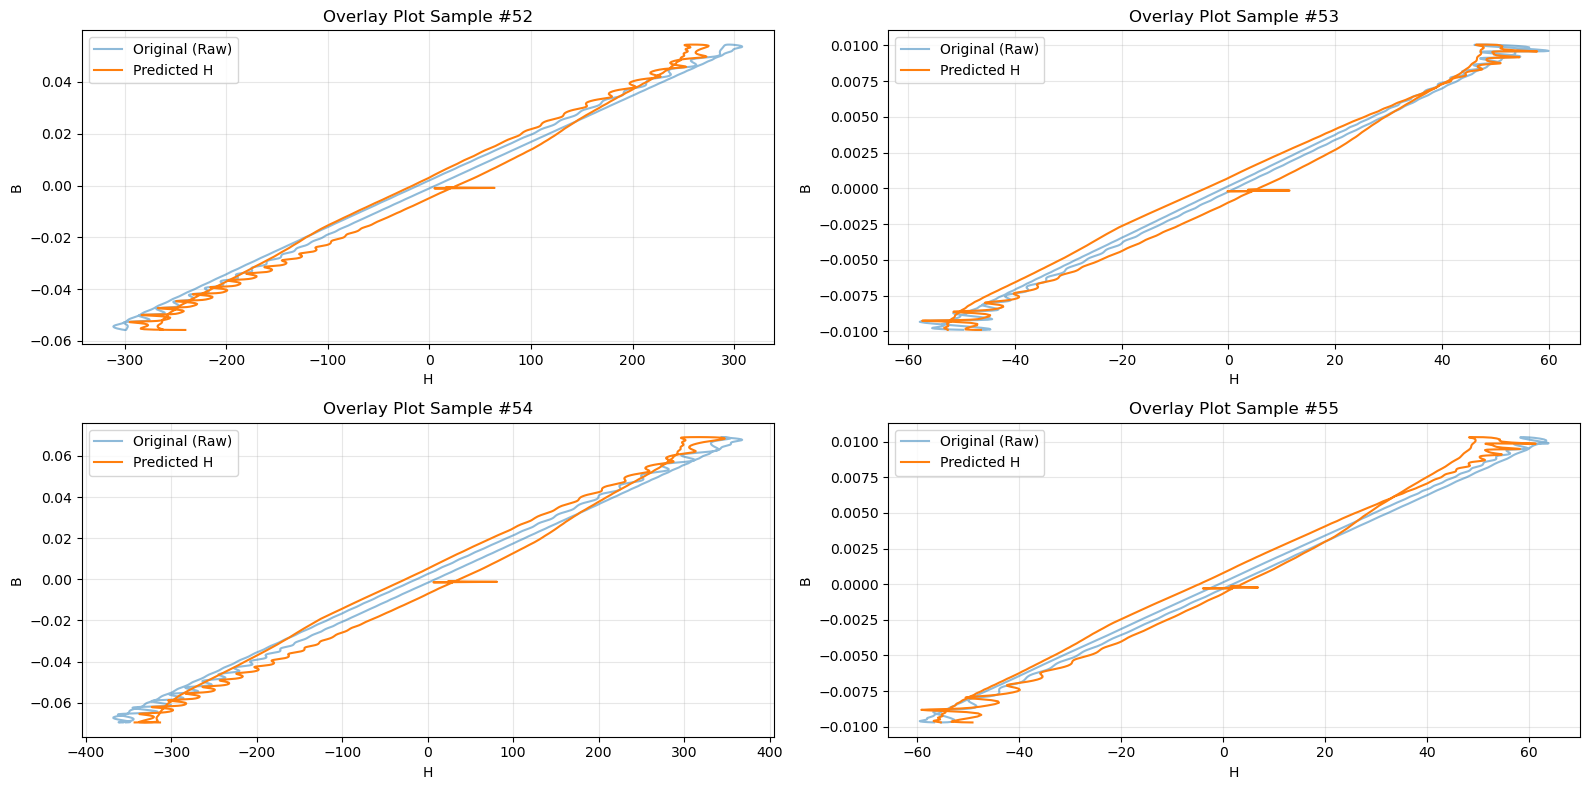

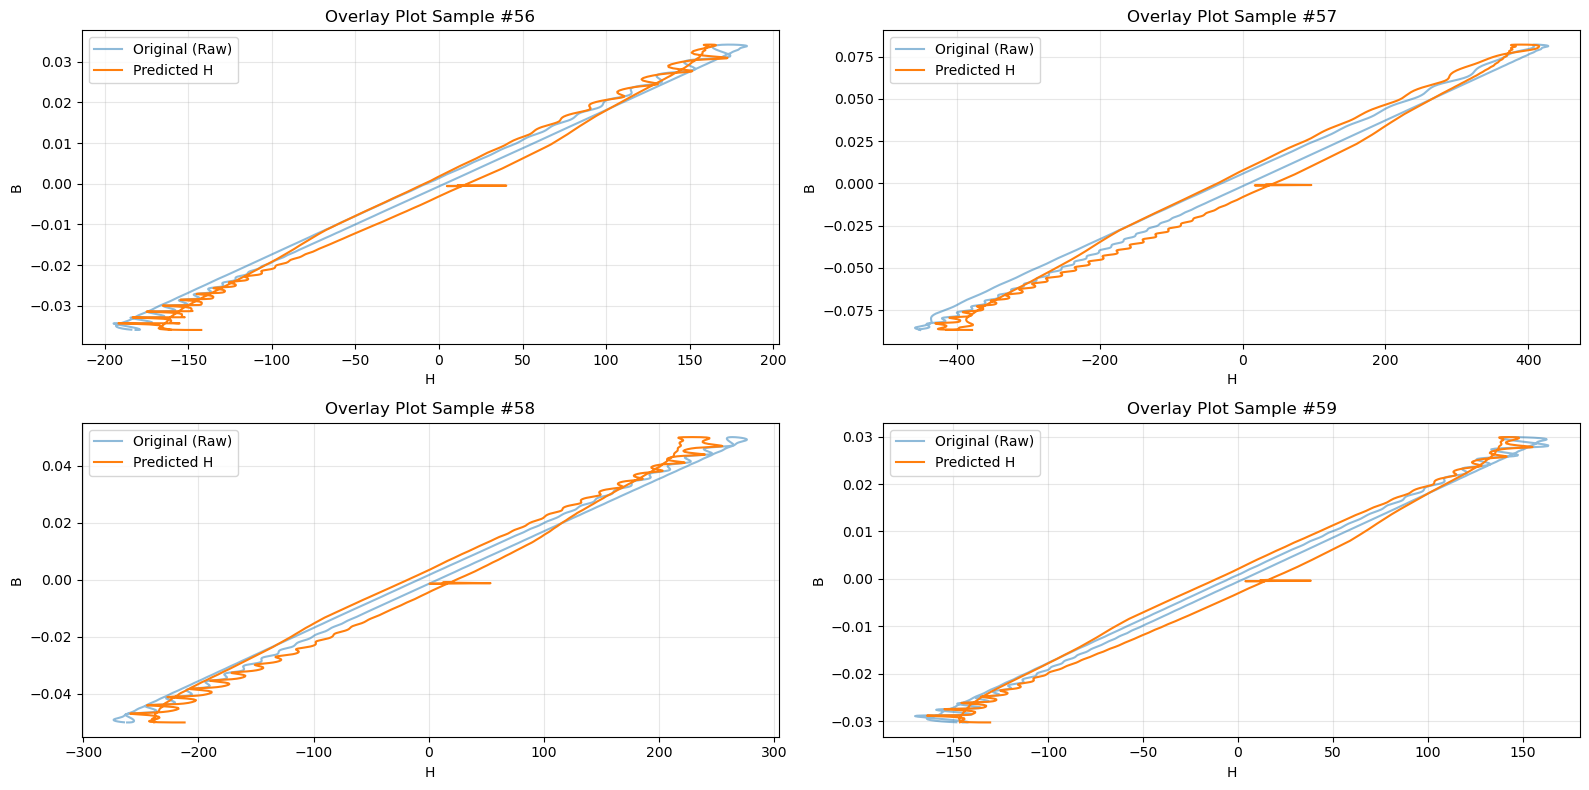

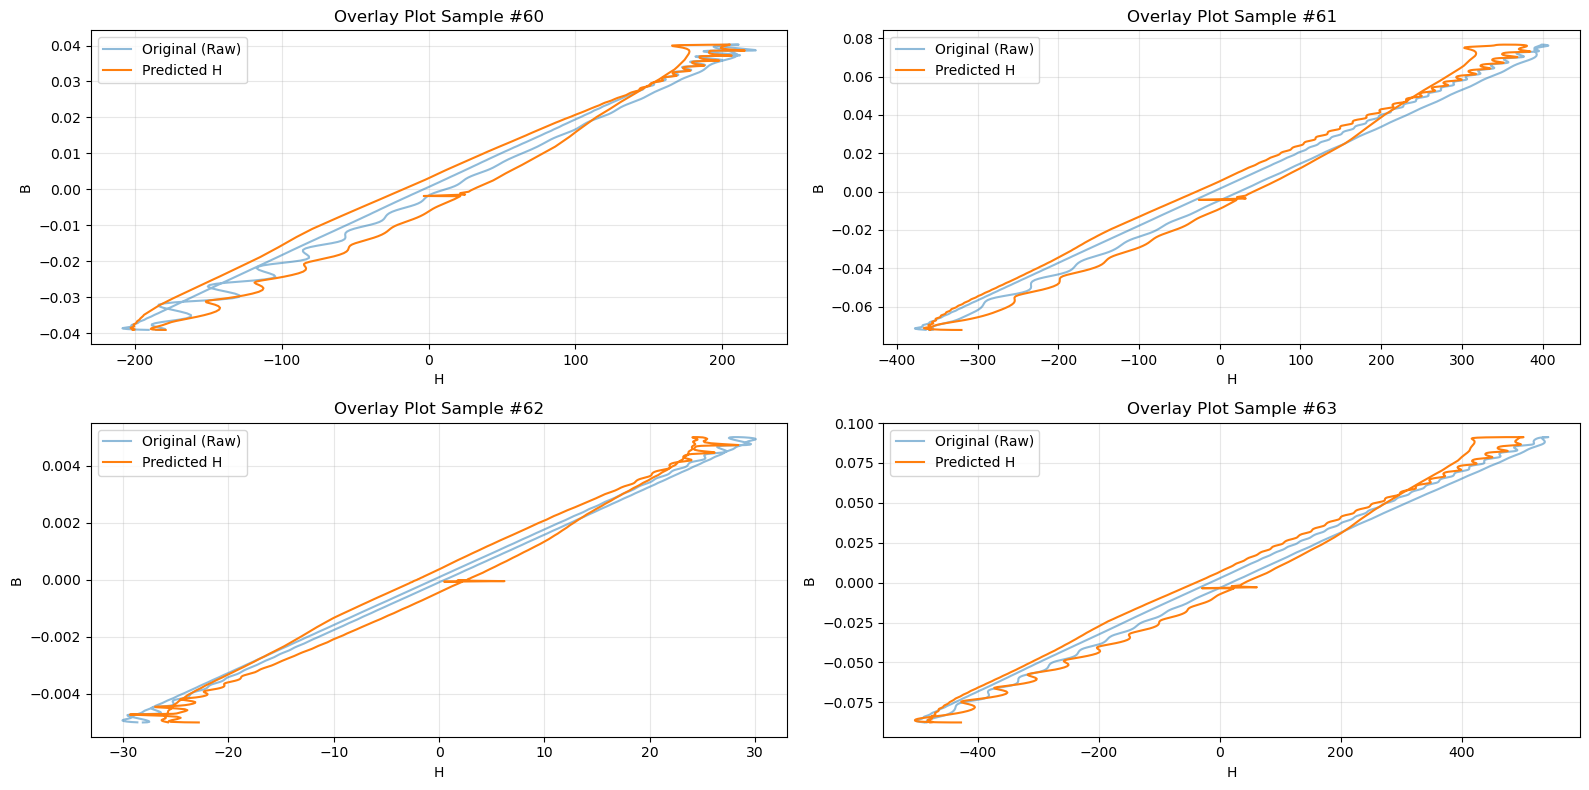

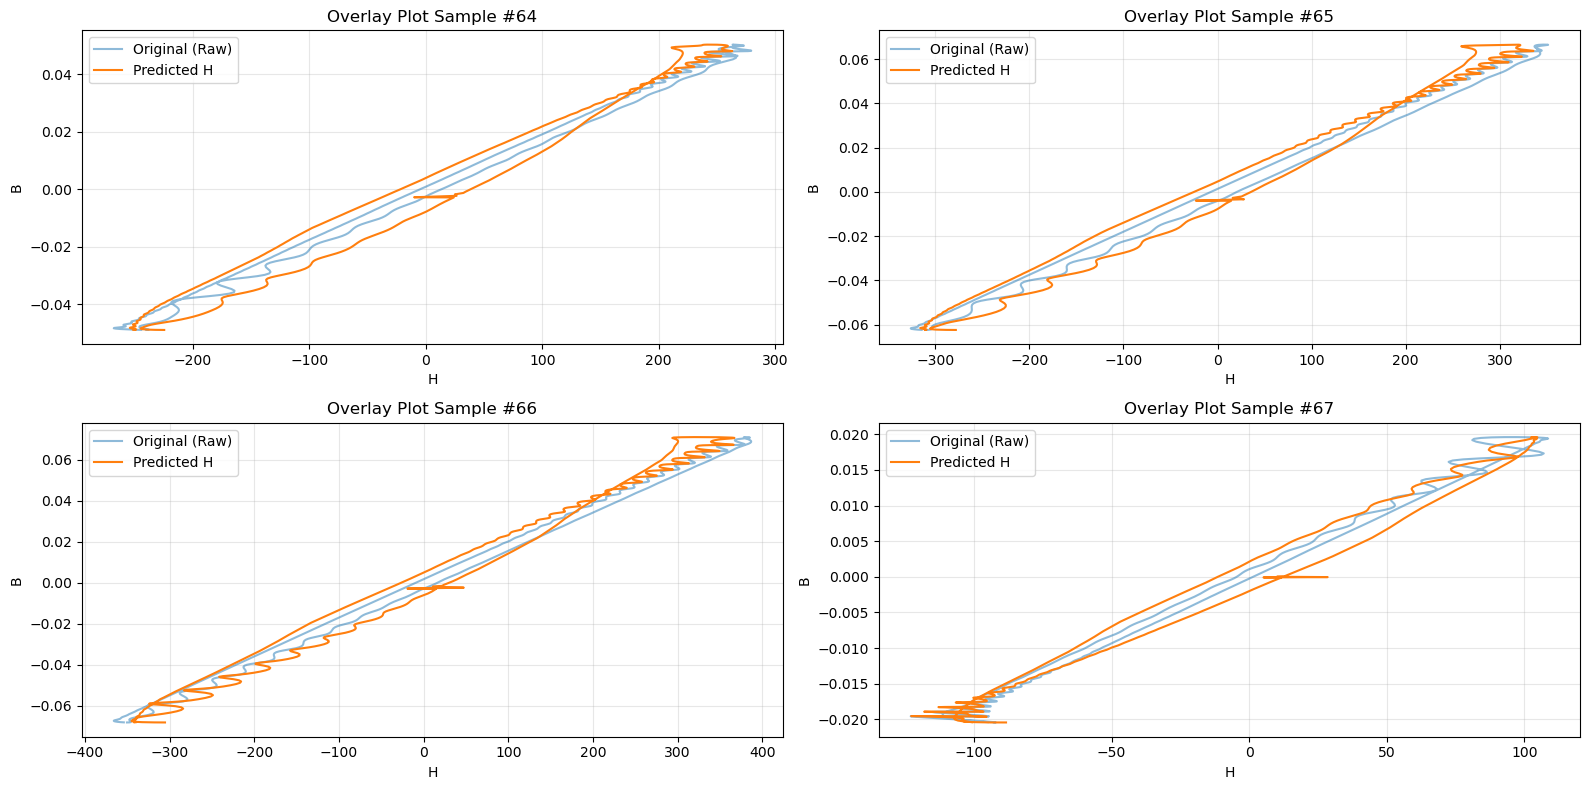

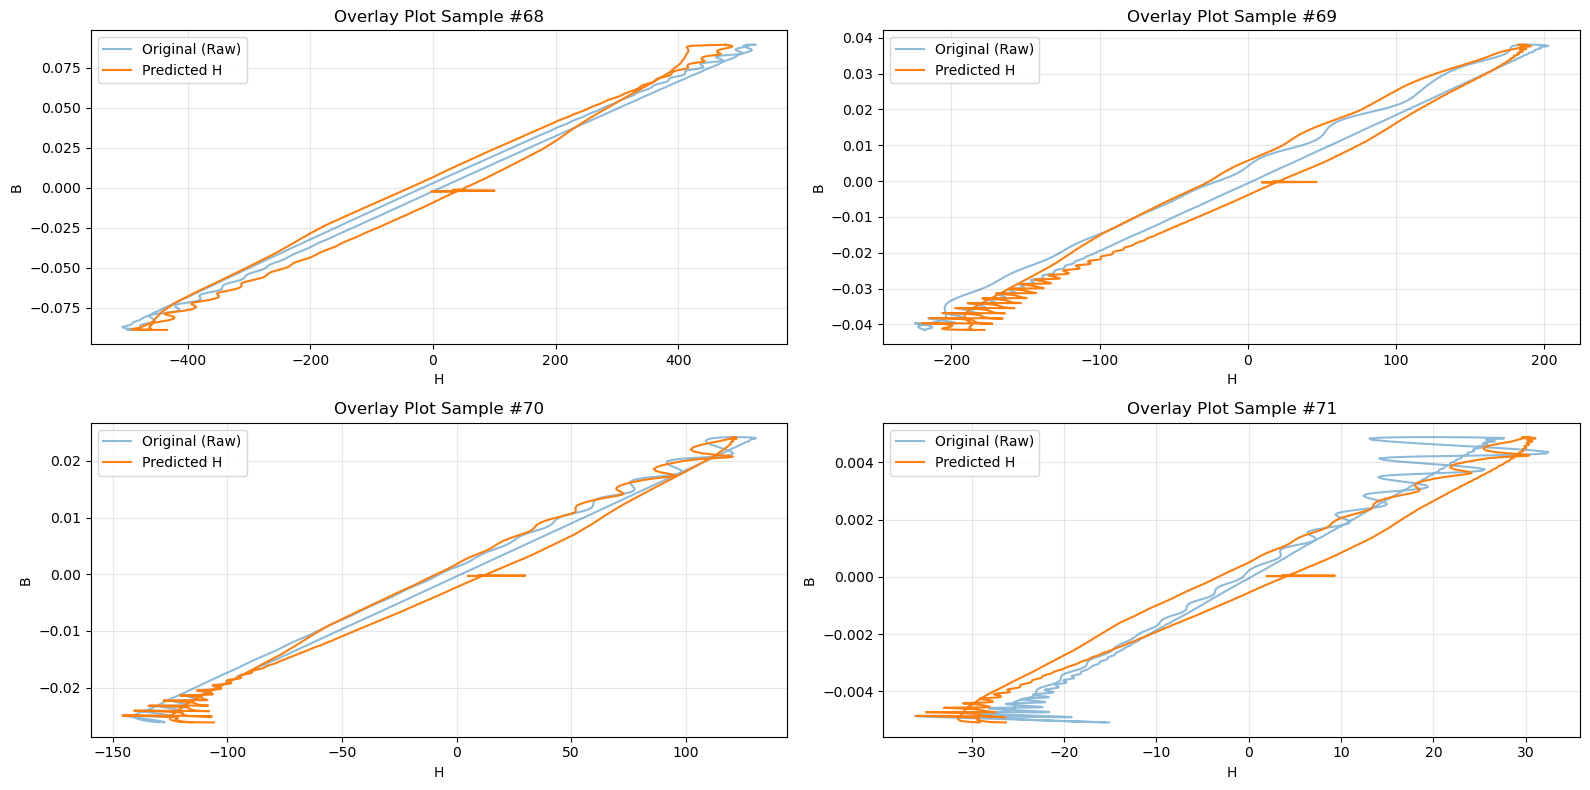

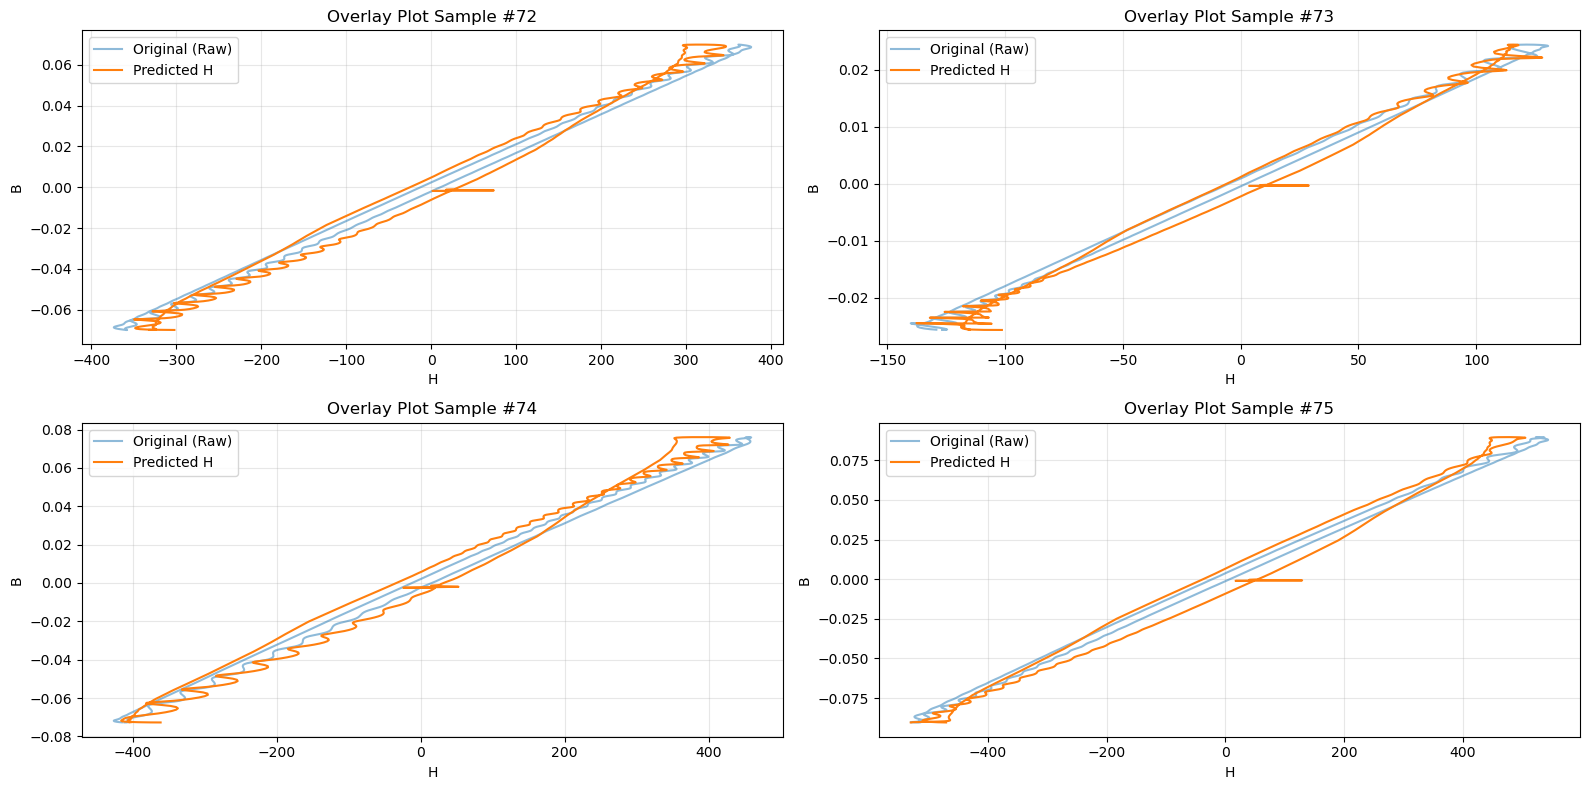

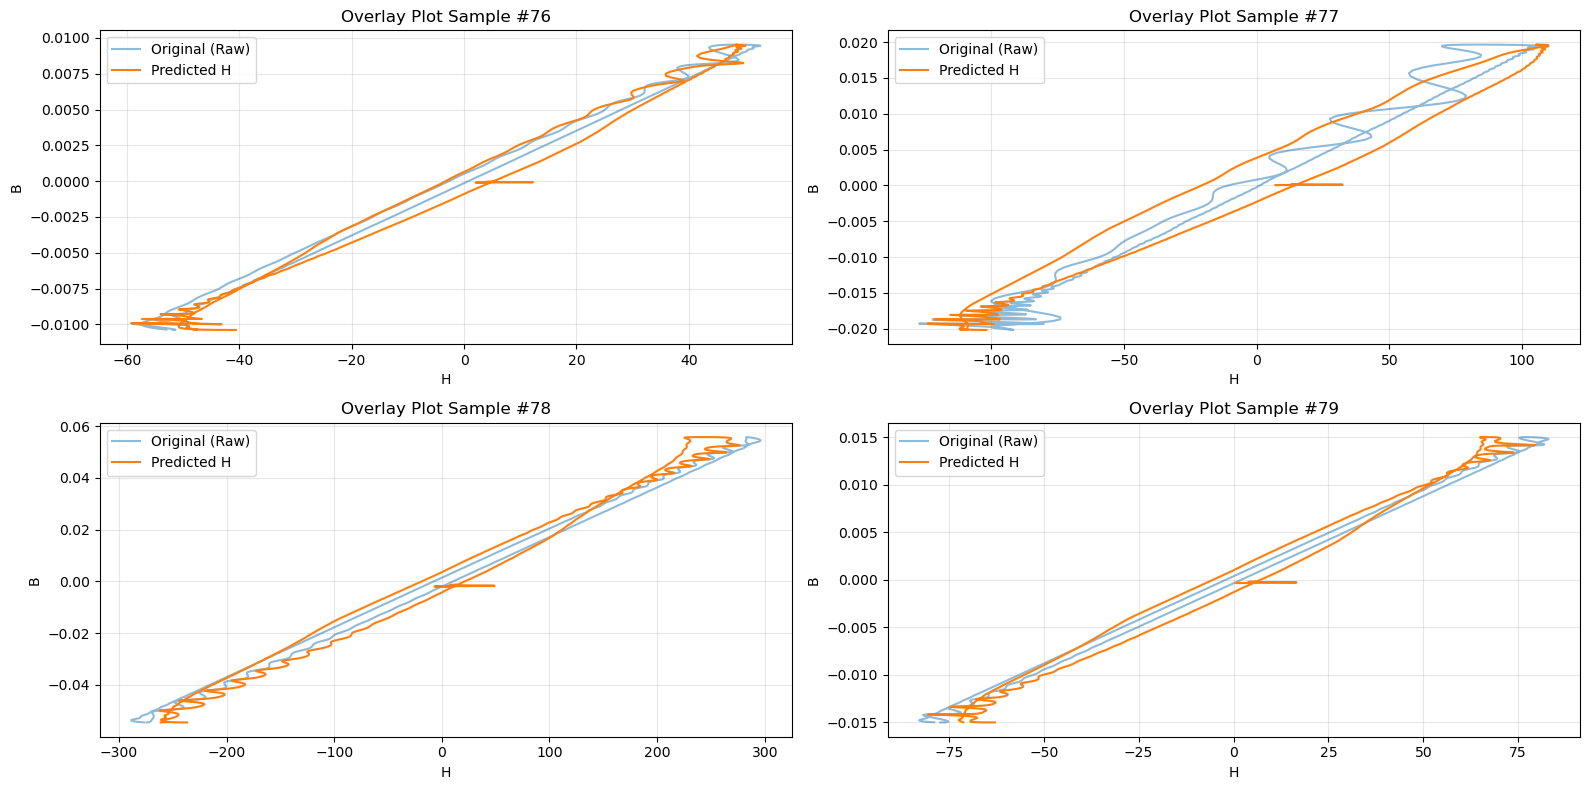

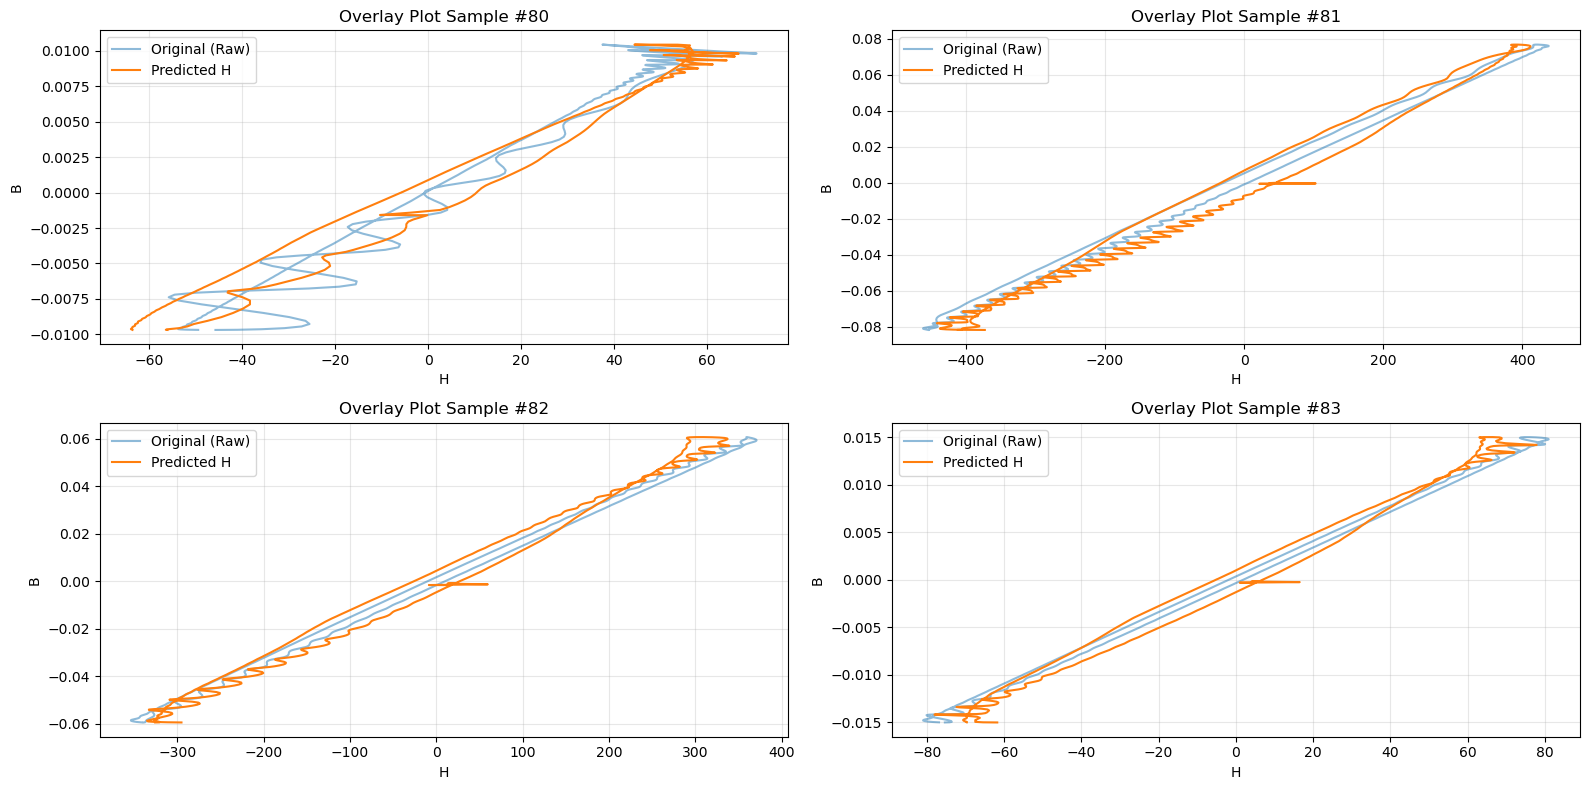

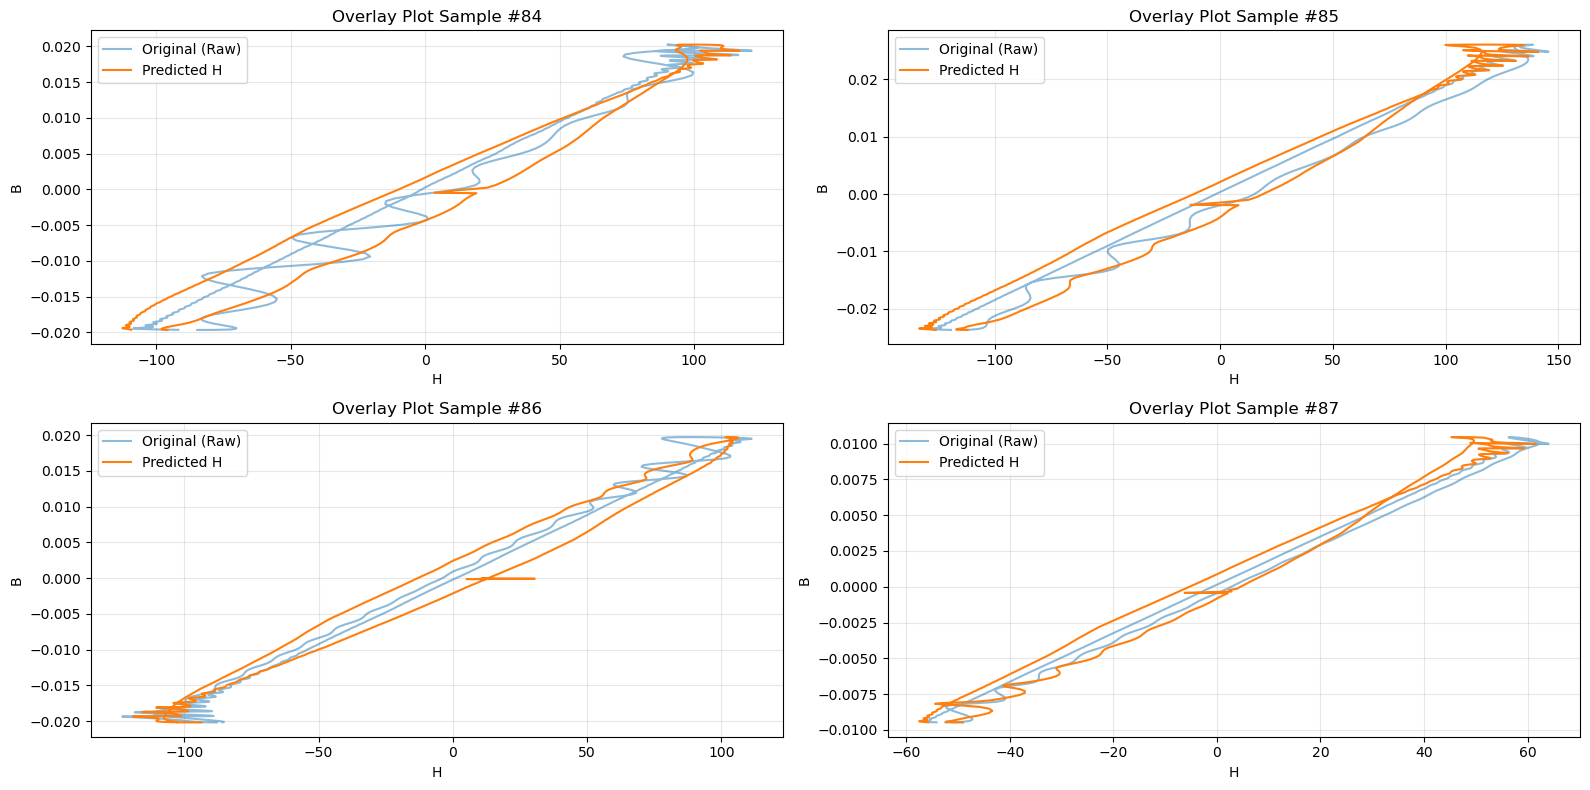

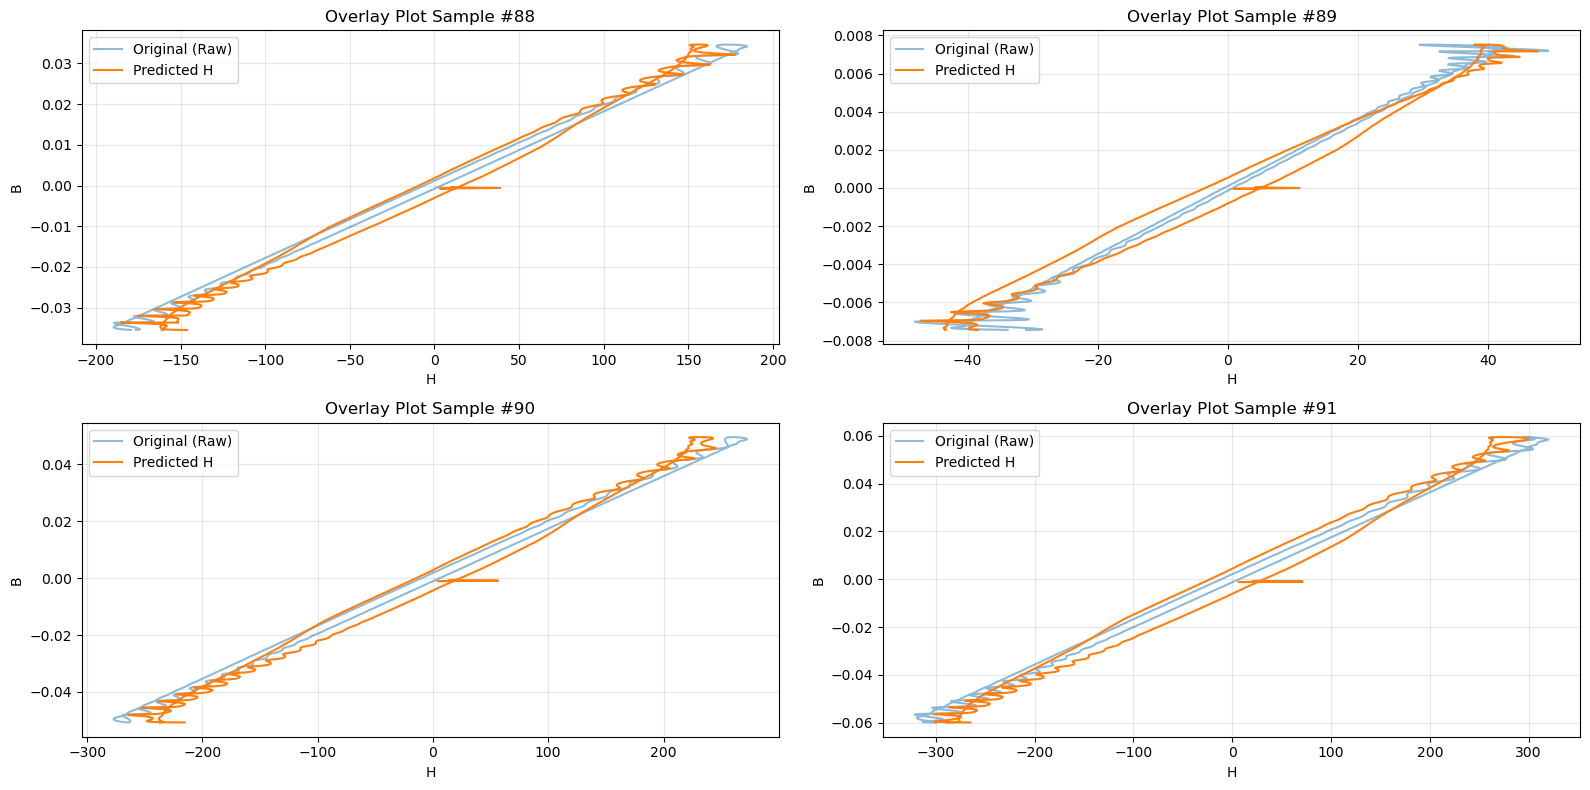

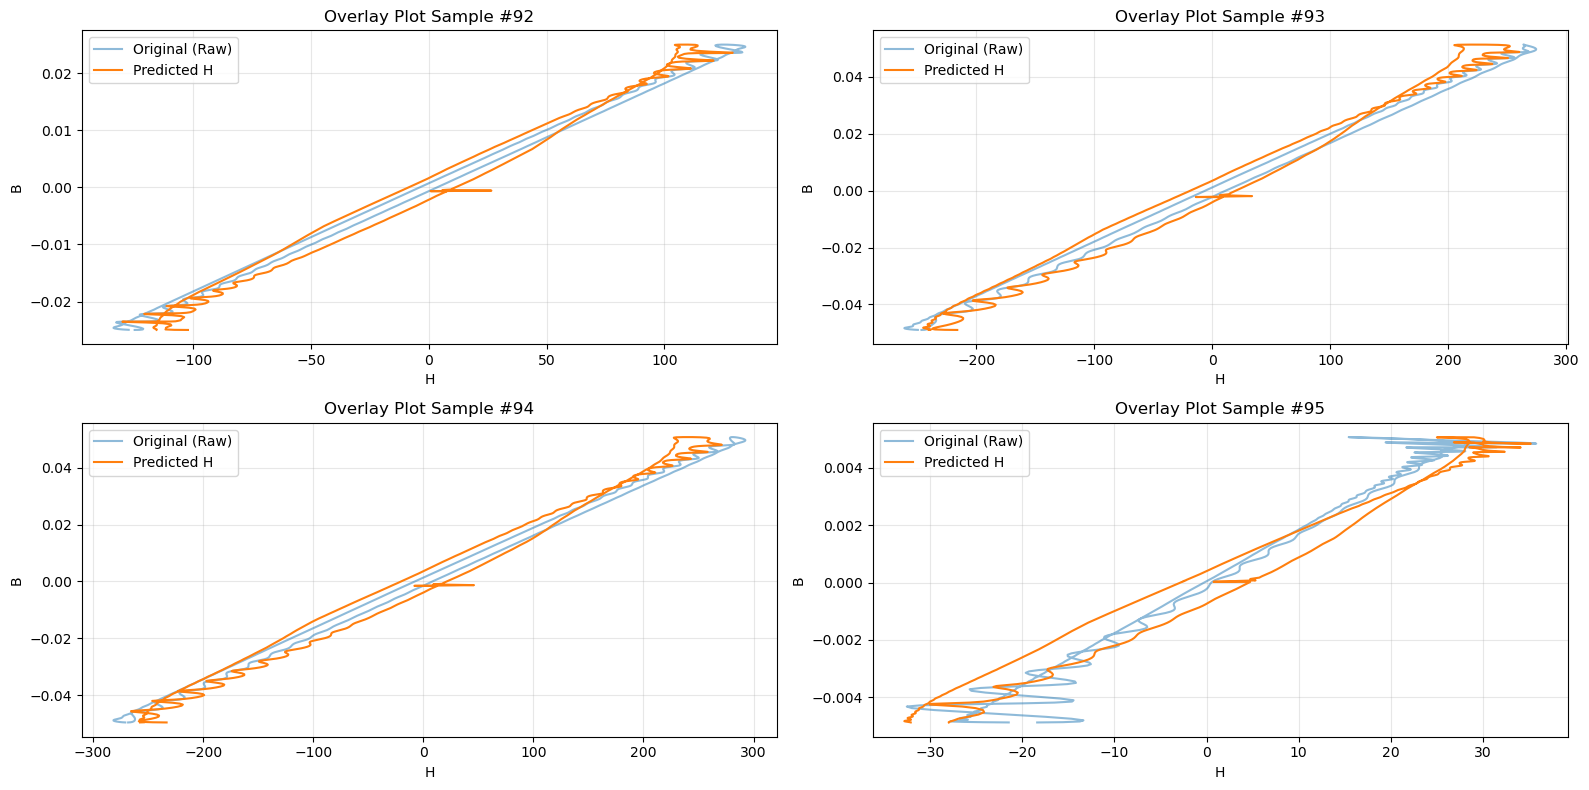

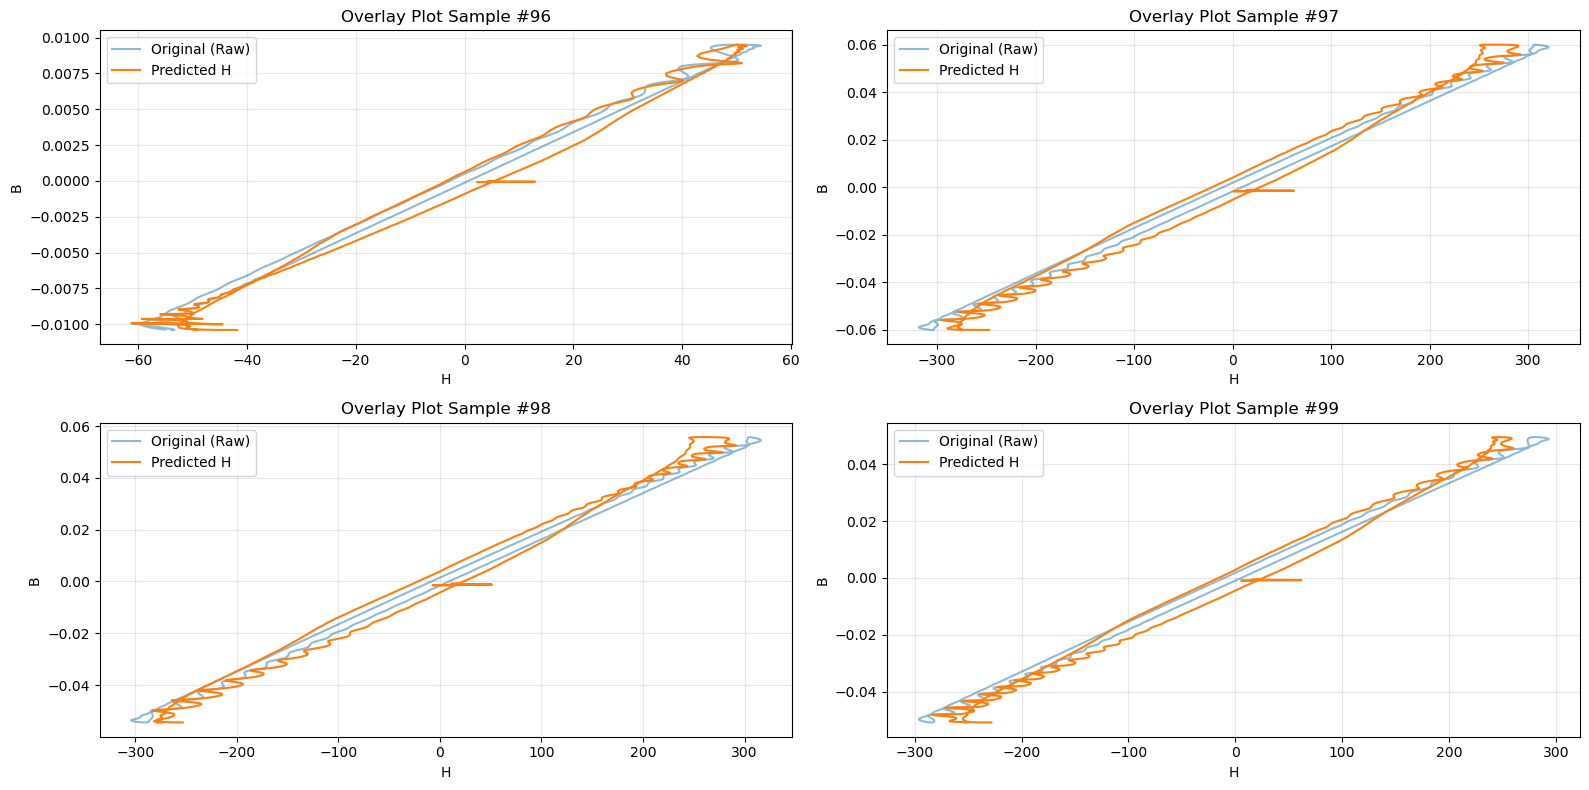

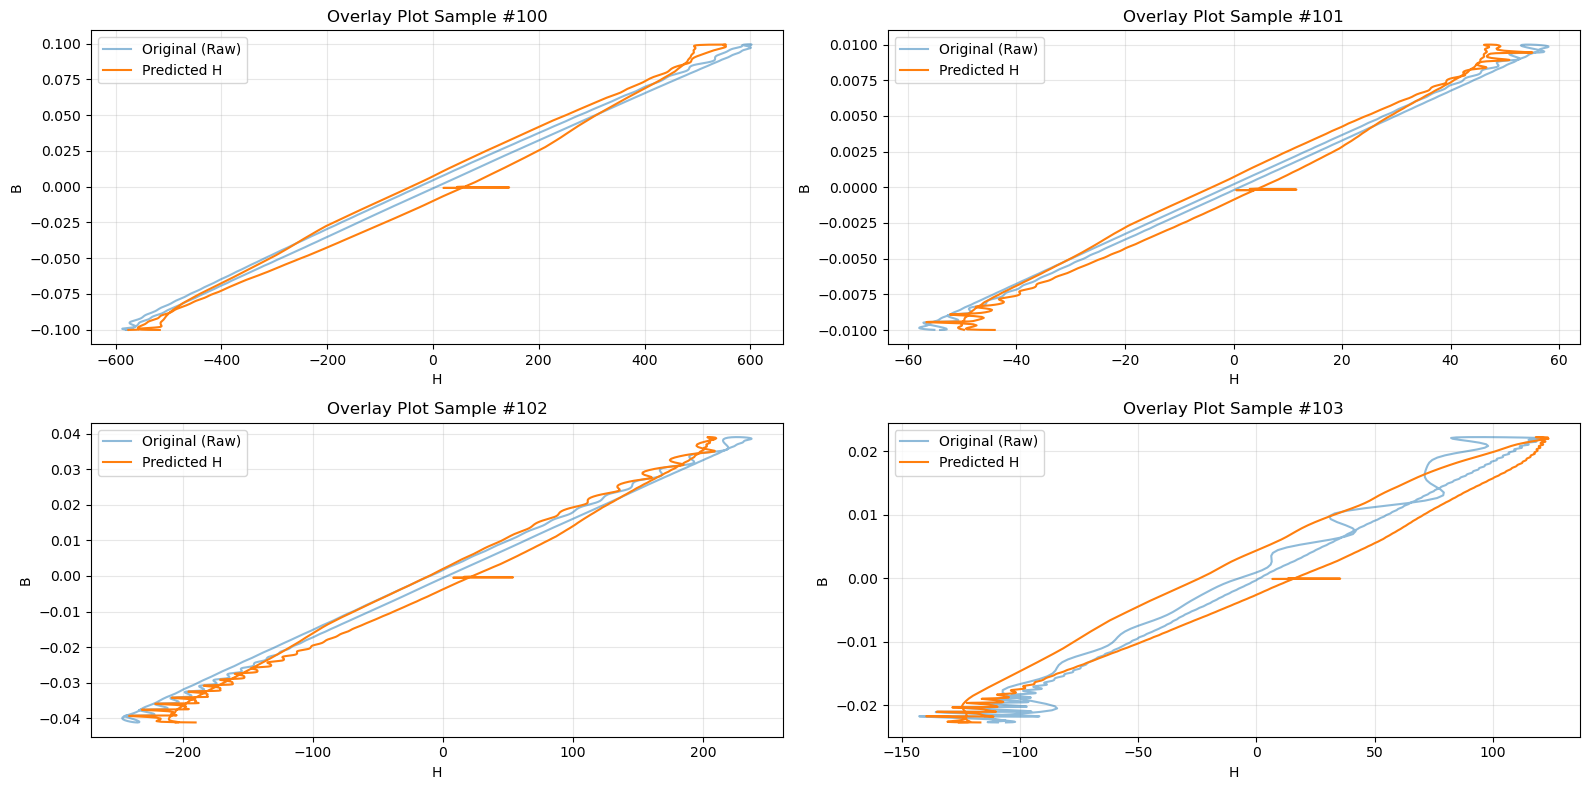

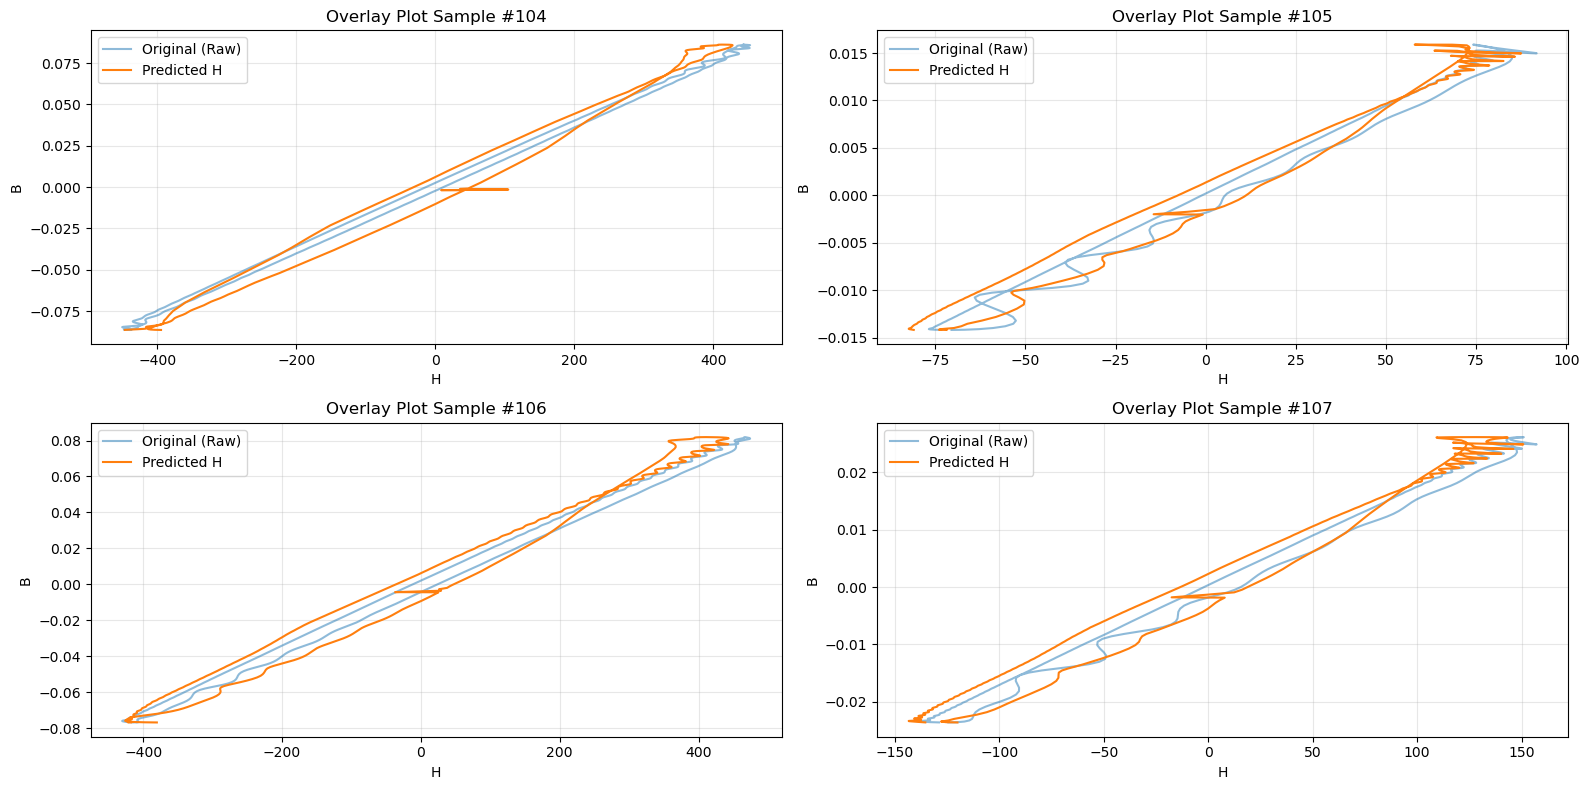

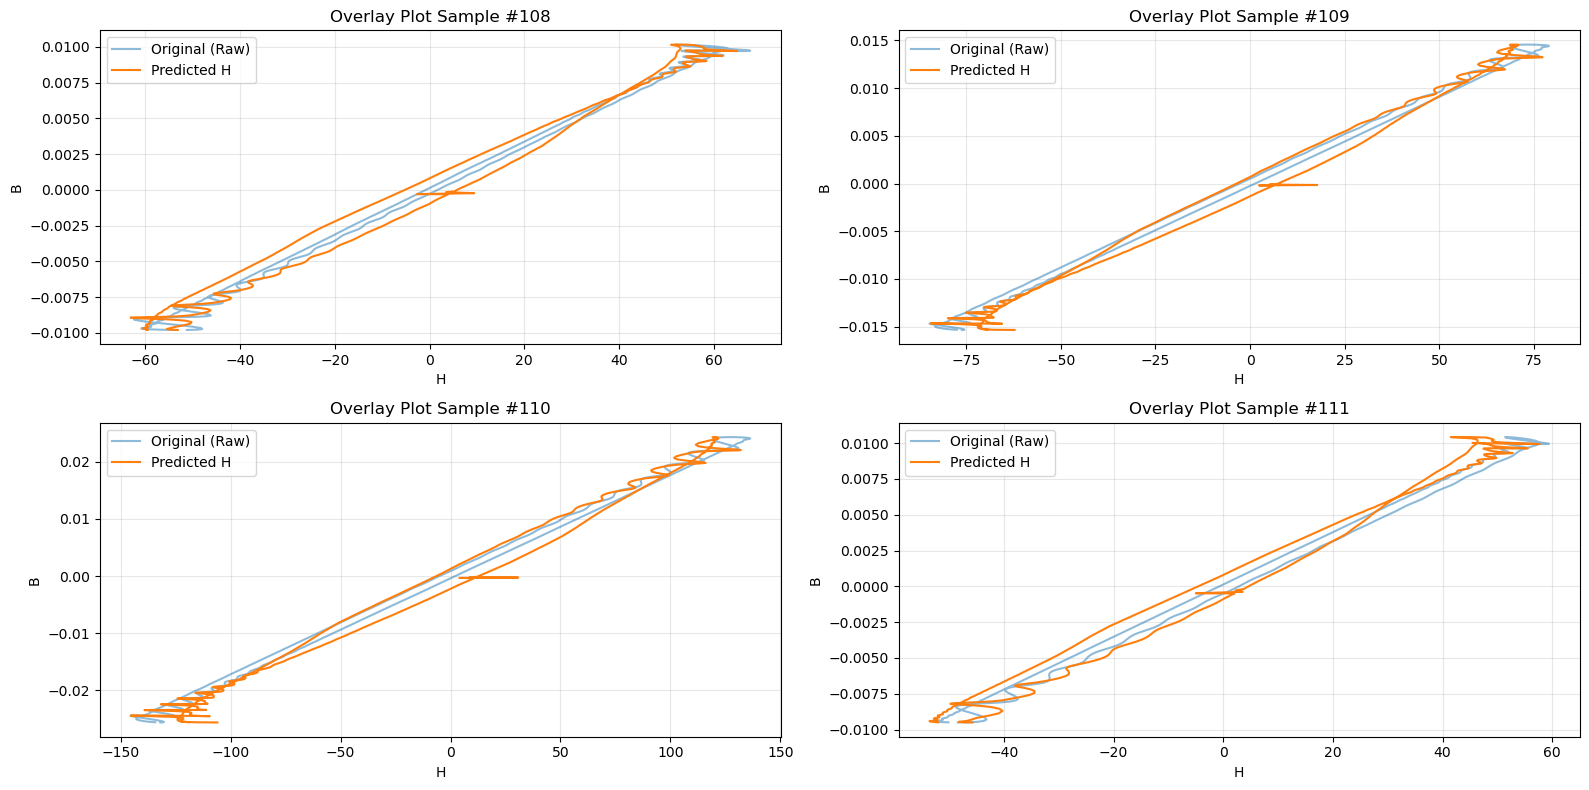

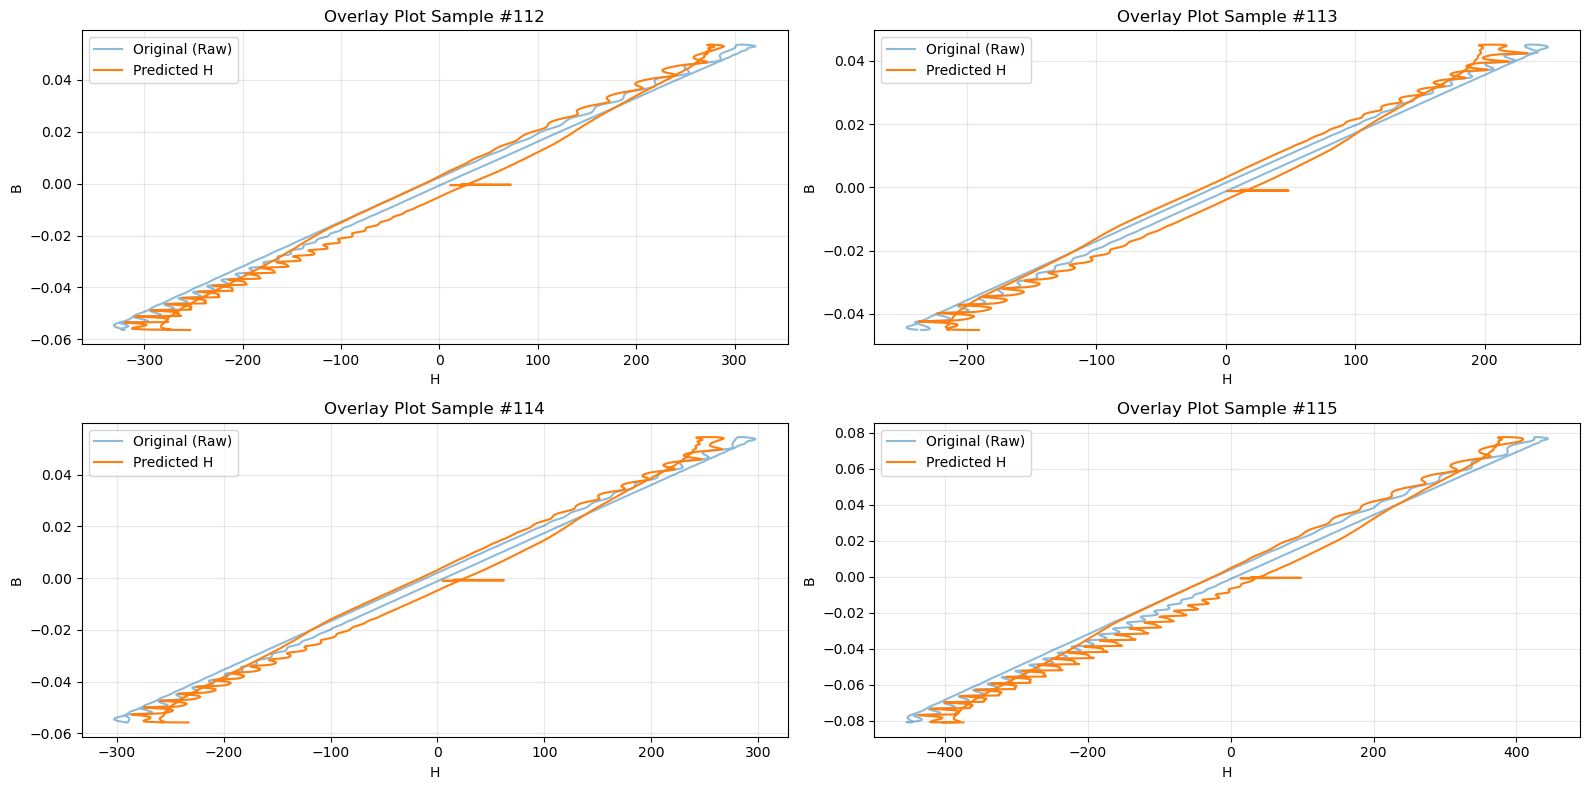

KeyboardInterrupt: 

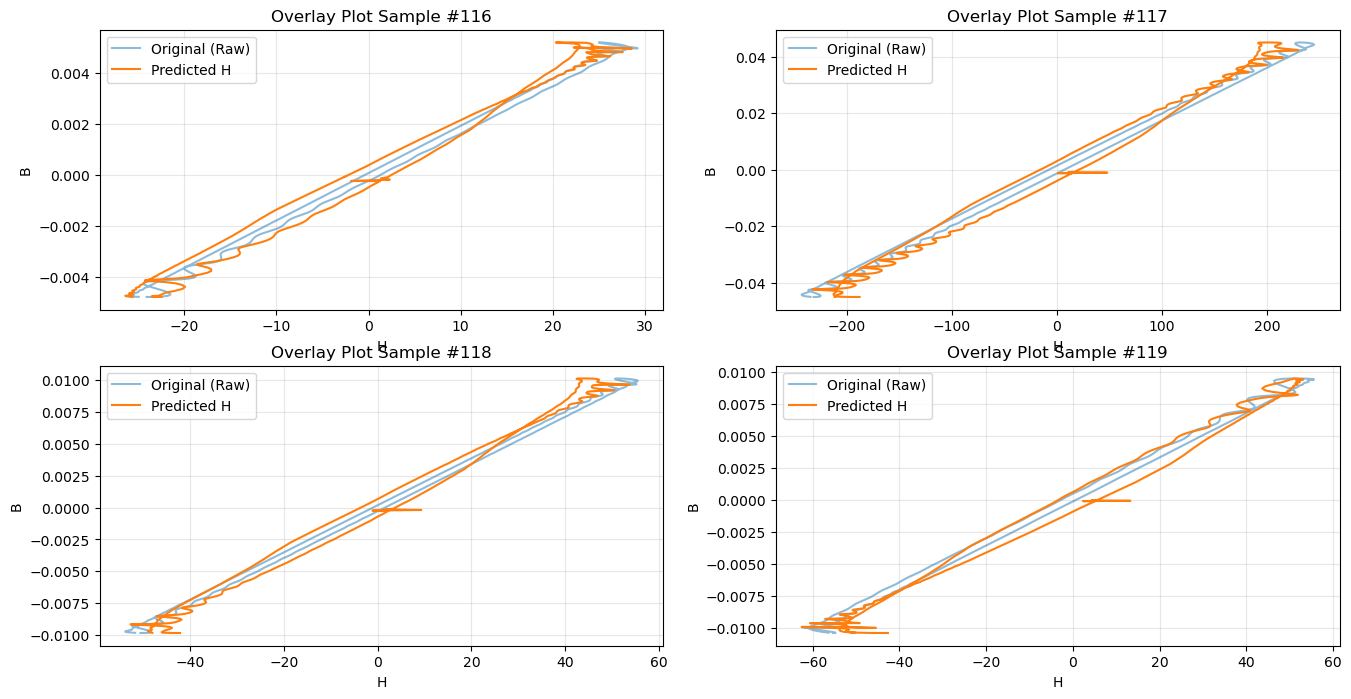

In [36]:
if __name__ == "__main__":

    # 取得原始資料（未降階）
    data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N = load_dataset(
        material)

    norm = normsDict[material]

    test_loader = get_dataloader(data_B, data_F, data_T, data_H, data_N,
                                 data_Hdc, data_Pcv, norm)

    test_model(test_loader, data_Pcv, data_B, data_H)